# Demo of Jeffrey Black's ML Model Development Experience for Fintech

The source of my data was pulled from https://www.kaggle.com/datasets/laotse/credit-risk-dataset. It appears the last time Kaggle updated this dataset was 4 years ago. 

# Data Acquisition & Preprocessing

Below you will find the packages that I used as well as the code to find the most recent csv in my `/data` file. Using pandas, this is converted into a dataframe. I also created a `relevant_features_list` list to store any features with strong relationships with the dependent variable. While this specific dataset does not have a lot of features, in my experience, running univariate statistical tests helps to reduce dataset size decreasing model complexity and improving computational times and feasibility of model development when considering speed to production. 

In [47]:
import black
import jupyter_black
import glob
import shutil
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, kendalltau
from itertools import combinations
from sklearn.metrics import mutual_info_score, f1_score, recall_score, precision_score, roc_auc_score, log_loss, roc_curve, auc, confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle

In [46]:
data_folder = '/Users/jeffreyblack/Projects/TrustageTechnicalProject/data'

# Ensure the data folder exists
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Define the file extensions you're interested in
file_extensions = ['csv', 'parquet', 'xlsx']

# Loop through each file extension and move the files
for extension in file_extensions:
    # Find all files in the current directory with the current extension
    for file in glob.glob(f"*.{extension}"):
        # Move each file to the data folder
        shutil.move(file, data_folder)


# finding and using most recent csv file
files = glob.glob('/Users/jeffreyblack/Projects/TrustageTechnicalProject/data/*.csv')
latest_file = max(files, key=os.path.getmtime)
df = pd.read_csv(latest_file)
relevant_features_list = []

In [3]:
display(df)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [4]:
pd.DataFrame(df.columns, columns = ['Column Names'])

,Column Names
0,person_age
1,person_income
2,person_home_ownership
3,person_emp_length
4,loan_intent
5,loan_grade
6,loan_amnt
7,loan_int_rate
8,loan_status
9,loan_percent_income


After examining the initial data, I found that some variables were binary or Y/N, and I preferred to make them boolean. I also noticed that the only ordinal data was the `Loan Grade`. I placed numbers before each of these to ease running a univariate statistical test later in the Exploratory Data Analysis below. I also changed the names of all the columns to better reflect the definition of each feature. Many times, I find that a more clear name for each feature eases in the interpretability of charts that I provide. When reducing cognitive load on my presentations, I find the information I am trying to convey is more easily digested. 

In [5]:
loan_status_replacement_map = {
    1: True, 
    0: False
}
cb_person_default_on_file_replacement_map = {
    'Y': True, 
    'N': False
}

loan_grade_map = {
    'A': '1) A', 
    'B': '2) B', 
    'C': '3) C', 
    'D': '4) D',
    'E': '5) E',
    'F': '6) F',
    'G': '7) G',
}
df.rename(columns = {'person_age':'Age', 
                     'person_income':'Income', 
                     'person_home_ownership':'Home Ownership', 
                     'person_emp_length':'Years of Employment', 
                     'loan_intent':'Loan Intent', 
                     'loan_grade':'Loan Grade', 
                     'loan_amnt':'Loan Amount', 
                     'loan_int_rate':'Loan Interest Rate',
                     'loan_status':'Default (target)', 
                     'loan_percent_income':'Loan Percent of Income', 
                     'cb_person_default_on_file':'History of Default', 
                     'cb_person_cred_hist_length':'Credit History Length'}, 
          inplace = True)
df['Default (target)'] = df['Default (target)'].map(loan_status_replacement_map)
df['History of Default'] = df['History of Default'].map(cb_person_default_on_file_replacement_map)
df['Loan Grade'] = df['Loan Grade'].map(loan_grade_map)

Examining the changes made: 

In [6]:
display(df)

,Age,Income,Home Ownership,Years of Employment,Loan Intent,Loan Grade,Loan Amount,Loan Interest Rate,Default (target),Loan Percent of Income,History of Default,Credit History Length
0,22,59000,RENT,123.0,PERSONAL,4) D,35000,16.02,True,0.59,True,3
1,21,9600,OWN,5.0,EDUCATION,2) B,1000,11.14,False,0.10,False,2
2,25,9600,MORTGAGE,1.0,MEDICAL,3) C,5500,12.87,True,0.57,False,3
3,23,65500,RENT,4.0,MEDICAL,3) C,35000,15.23,True,0.53,False,2
4,24,54400,RENT,8.0,MEDICAL,3) C,35000,14.27,True,0.55,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,3) C,5800,13.16,False,0.11,False,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,1) A,17625,7.49,False,0.15,False,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,2) B,35000,10.99,True,0.46,False,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,2) B,15000,11.48,False,0.10,False,26


Evaluating the number of `NULL` values by column, I observed that about 3% of rows had `NULL` values for `Years of Employment`. I also observed that just under 10% of rows had `NULL` values for `Loan Interest Rate`.

In [7]:
pd.DataFrame(df.isnull().sum(), columns = ['Nulls'])

,Nulls
Age,0
Income,0
Home Ownership,0
Years of Employment,895
Loan Intent,0
Loan Grade,0
Loan Amount,0
Loan Interest Rate,3116
Default (target),0
Loan Percent of Income,0


As a step in understanding the data, I examined how many Unique Values exist per column. This is also a great chance to investigate if there may be data quality issues. 

In [8]:
pd.DataFrame(df.nunique(), columns = ['Unique Values'])

,Unique Values
Age,58
Income,4295
Home Ownership,4
Years of Employment,36
Loan Intent,6
Loan Grade,7
Loan Amount,753
Loan Interest Rate,348
Default (target),2
Loan Percent of Income,77


As a step in understanding the data, I examined each columns data types. This is also a great chance to investigate if there may be data quality issues. 

In [9]:
pd.DataFrame(df.dtypes, columns = ['Data Types'])

,Data Types
Age,int64
Income,int64
Home Ownership,object
Years of Employment,float64
Loan Intent,object
Loan Grade,object
Loan Amount,int64
Loan Interest Rate,float64
Default (target),bool
Loan Percent of Income,float64


# Exploratory Data Analysis

The statistical summary of the dataset indicates data quality issues. The maximum `Age` listed is 144 years, exceeding the documented longest lifespan of 122 years. It also records `Years of Employment` duration up to 123 years, which is unrealistic. These points suggest inaccuracies in the data.

To correct this, I will limit the `Age` in the dataset to 122 years, considering a lower threshold might be more appropriate pending a review of organizational policies to prevent age discrimination. Since most people have employment lasting around 50 years. I am going to set a threshold at 70 years for `Years of Employment`. This too would warrant investigation into organizational policies. Finally, if the `Years of Employment` exceeds a `Age` minus 14 (the legal age for employment in non-hazardous agricultural work), then it will be removed. 

Furthermore, the dataset shows entries with a `Loan Percent of Income` at 0, indicating a potential error that needs investigation. 

In [10]:
df.describe()

,Age,Income,Years of Employment,Loan Amount,Loan Interest Rate,Loan Percent of Income,Credit History Length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000


In [11]:
df.describe(include=['object', 'bool'])

,Home Ownership,Loan Intent,Loan Grade,Default (target),History of Default
count,32581,32581,32581,32581,32581
unique,4,6,7,2,2
top,RENT,EDUCATION,1) A,False,False
freq,16446,6453,10777,25473,26836


Setting the data quality parameters and replacing what is believed to be erroneous values with `NULL`.

In [12]:
# Set age values outside 18 to 122 years old to NaN
df['Age'] = df['Age'].where((df['Age'] >= 18) & (df['Age'] <= 122), np.nan)

# Set years of employment exceeding 70 years to NaN
df['Years of Employment'] = df['Years of Employment'].where(df['Years of Employment'] <= 70, np.nan)

# Set years of employment to NaN if it exceeds Age - 14 years
df['Years of Employment'] = df.apply(lambda row: row['Years of Employment'] if row['Years of Employment'] <= (row['Age'] - 14) else np.nan, axis=1)

Updated `NULL` values after data quality adjustments: 

In [13]:
pd.DataFrame(df.isnull().sum(), columns = ['Nulls'])

,Nulls
Age,5
Income,0
Home Ownership,0
Years of Employment,902
Loan Intent,0
Loan Grade,0
Loan Amount,0
Loan Interest Rate,3116
Default (target),0
Loan Percent of Income,0


Visualizing the distributions of each feature individually: 

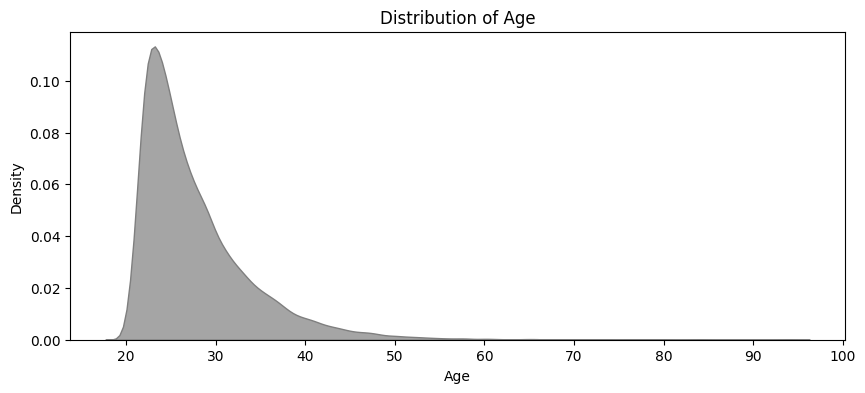

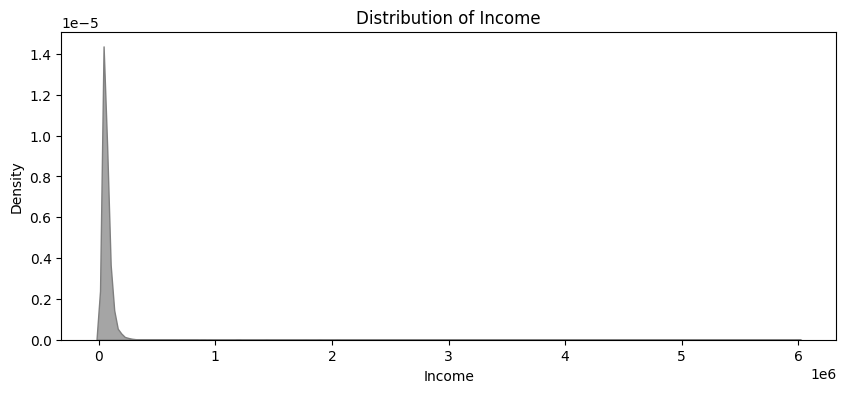

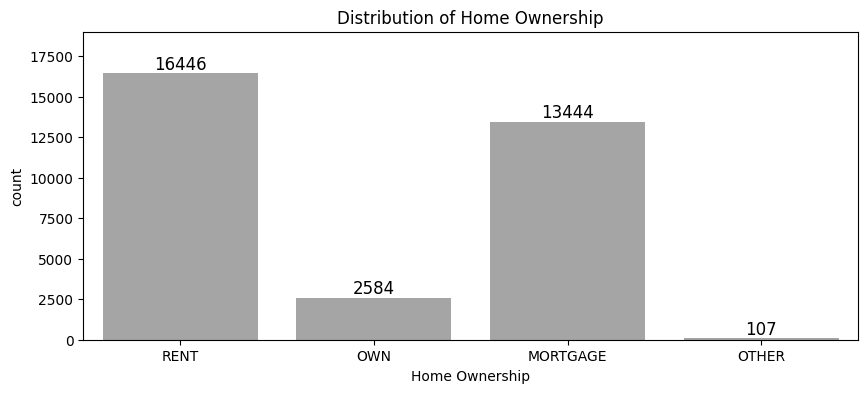

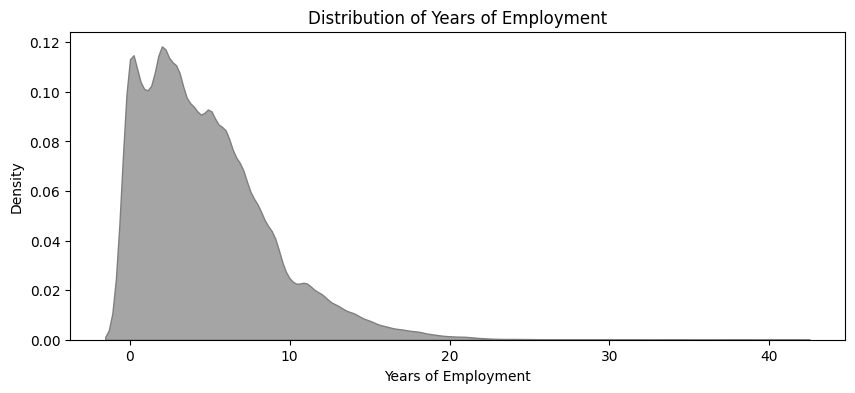

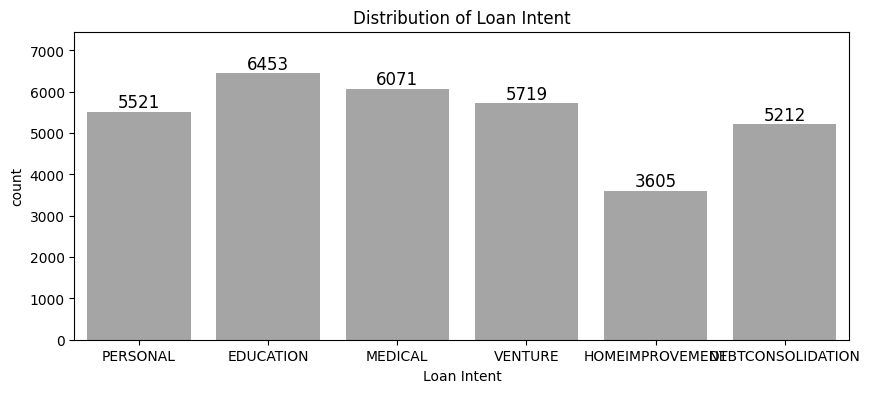

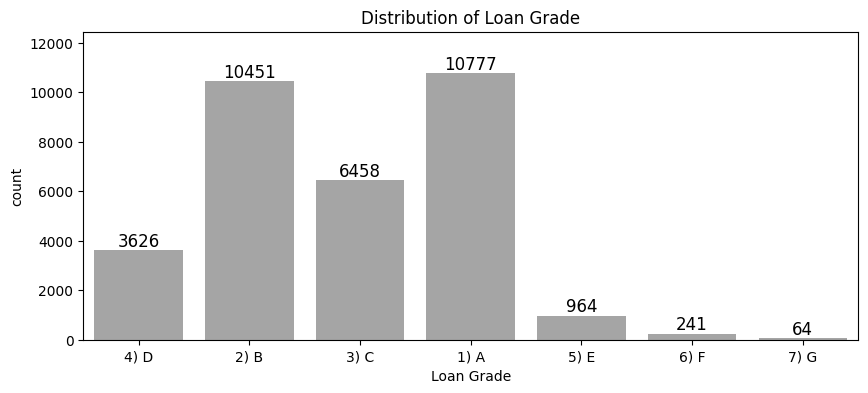

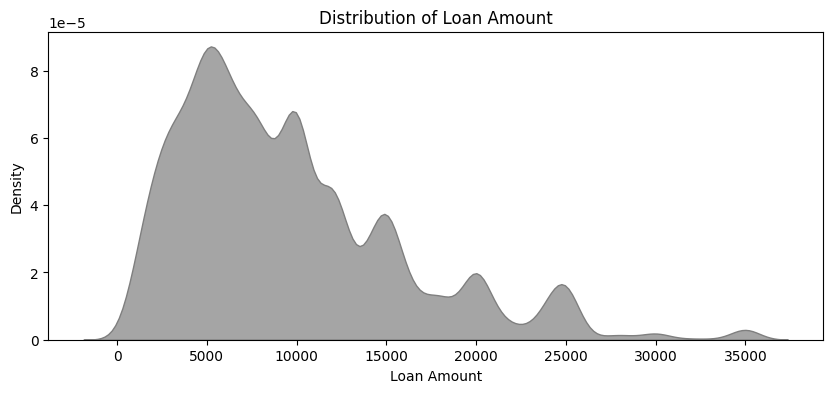

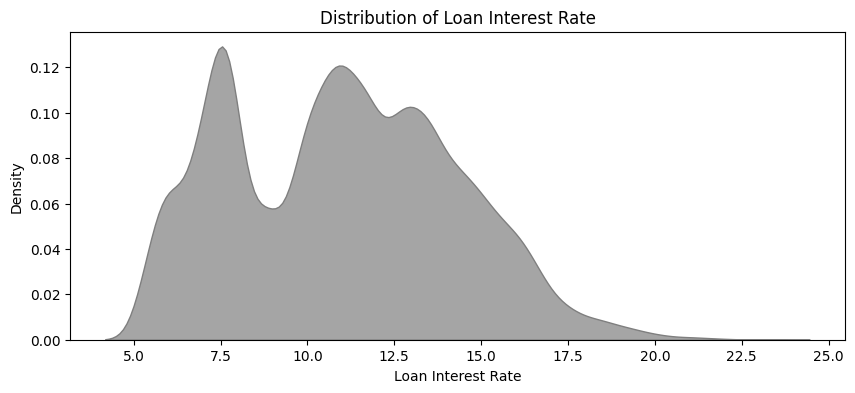

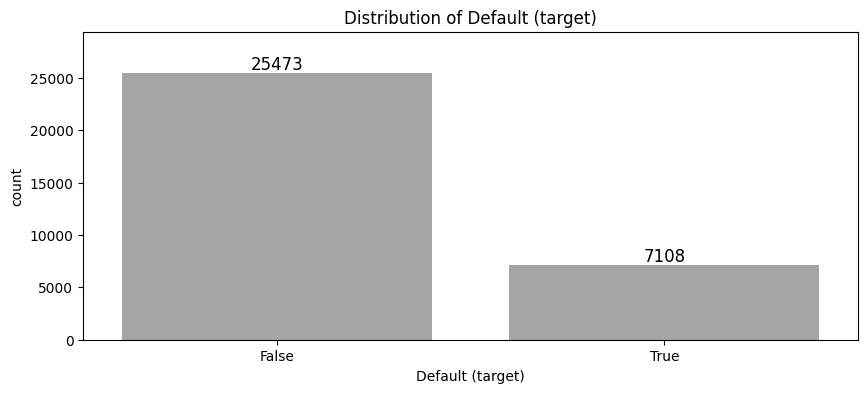

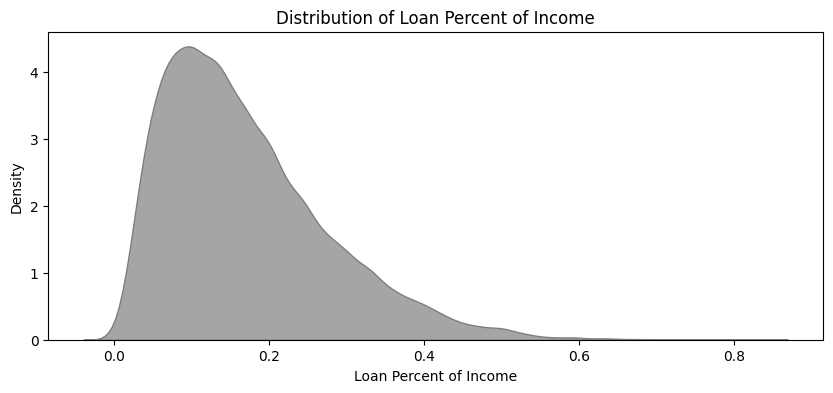

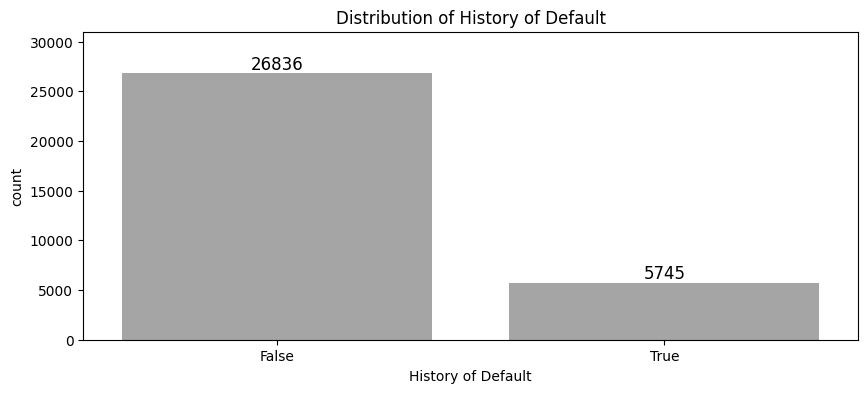

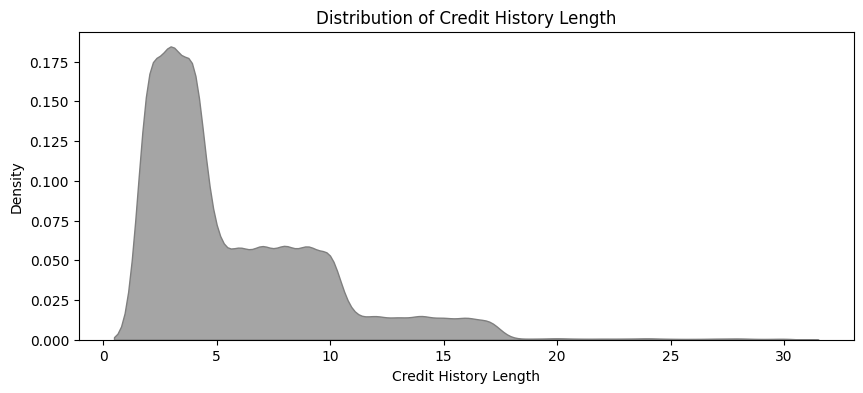

In [14]:
for column in df.columns:
    plt.figure(figsize=(10, 4))
    plt.title(f'Distribution of {column}')
    
    # Check data type of the column
    if df[column].dtype == 'object' or df[column].dtype == 'bool':
        # For categorical data
        ax = sns.countplot(x=column, data=df, color = 'tab:gray', fill=True, alpha=.7)

        # Add labels on top of each bar
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()),
                    fontsize=12, ha='center', va='bottom')
        y_max = ax.get_ylim()[1]  
        ax.set_ylim(0, y_max * 1.1)  # Increase the maximum y value by 10% to prevent label cutoff
        plt.show()
        
    else:
        # For continuous data
        sns.kdeplot(x=df[column], color = 'tab:gray', fill=True, alpha=0.7)
    
    plt.show()

Visualizing the distributions of each feature by `Default (target)`: 

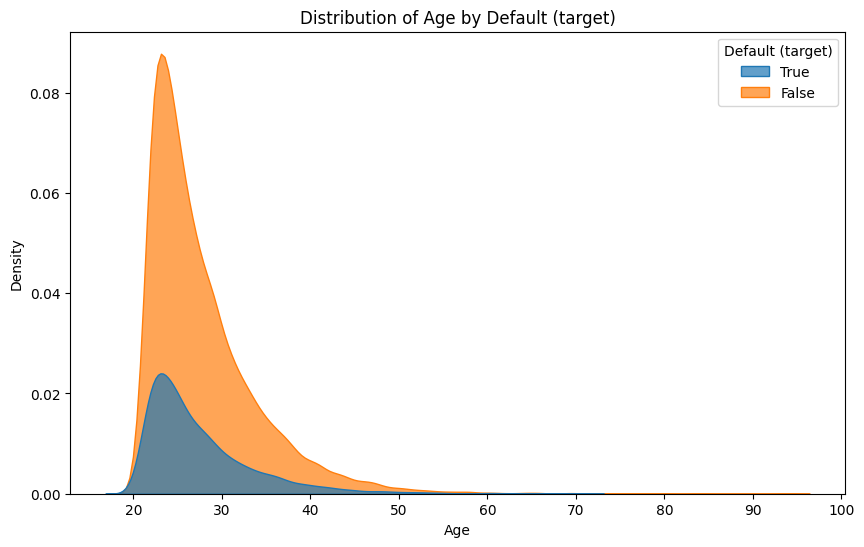

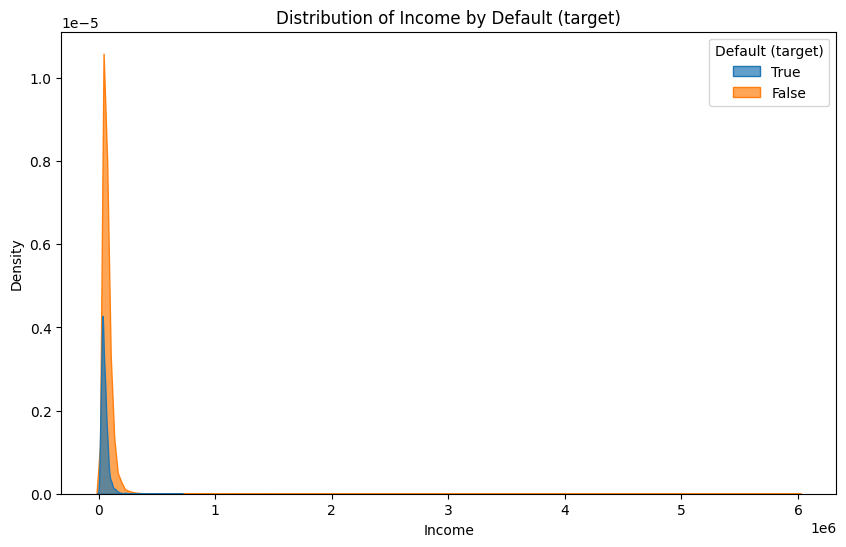

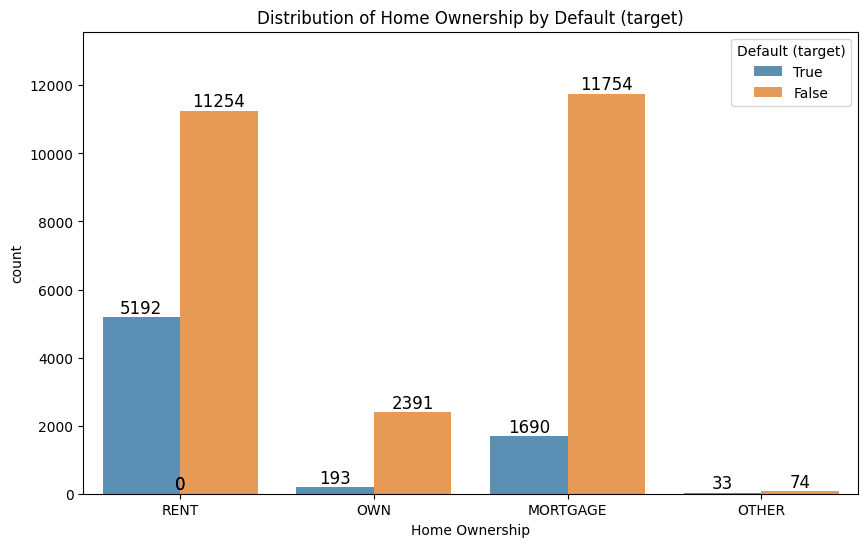

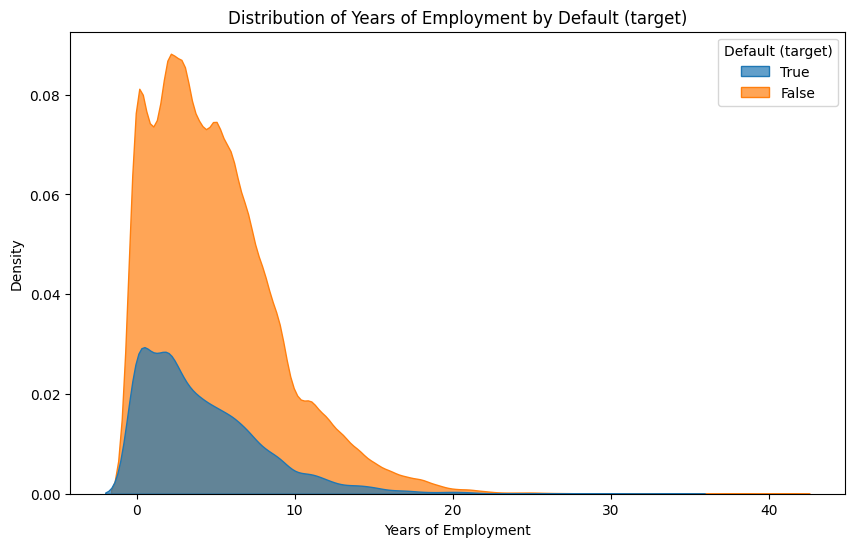

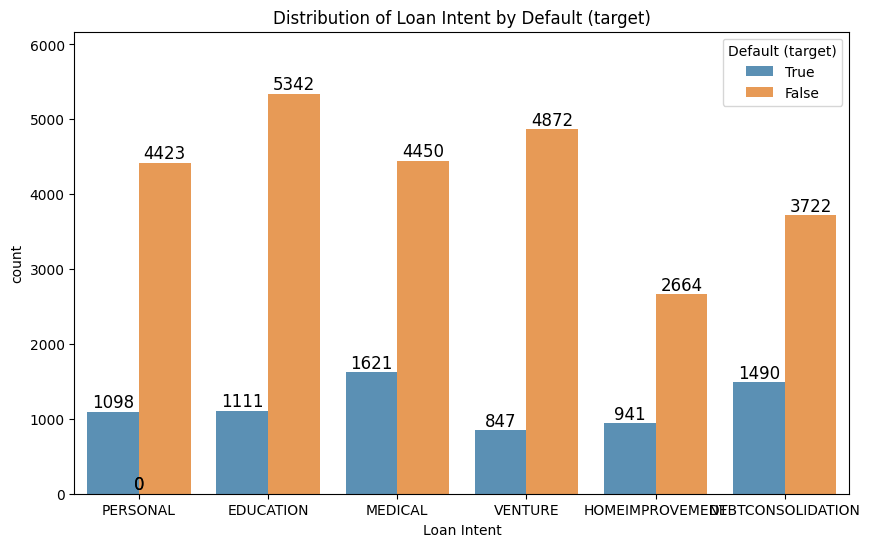

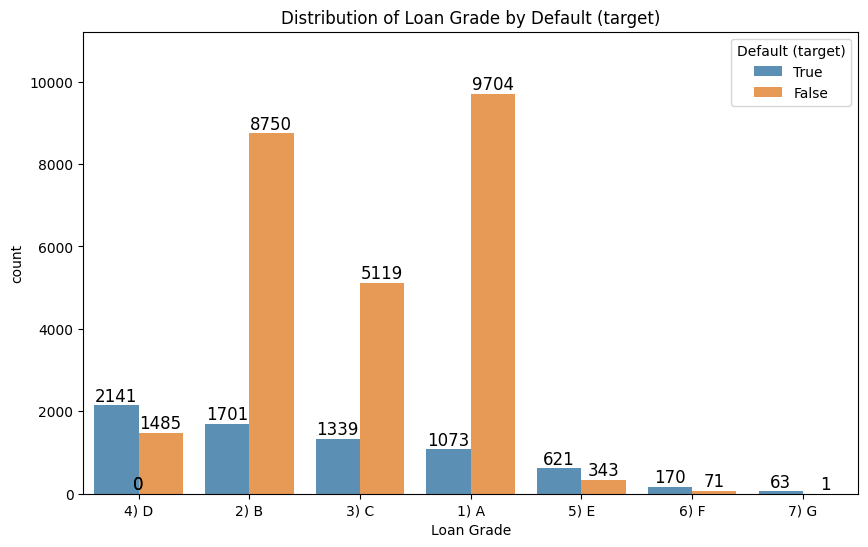

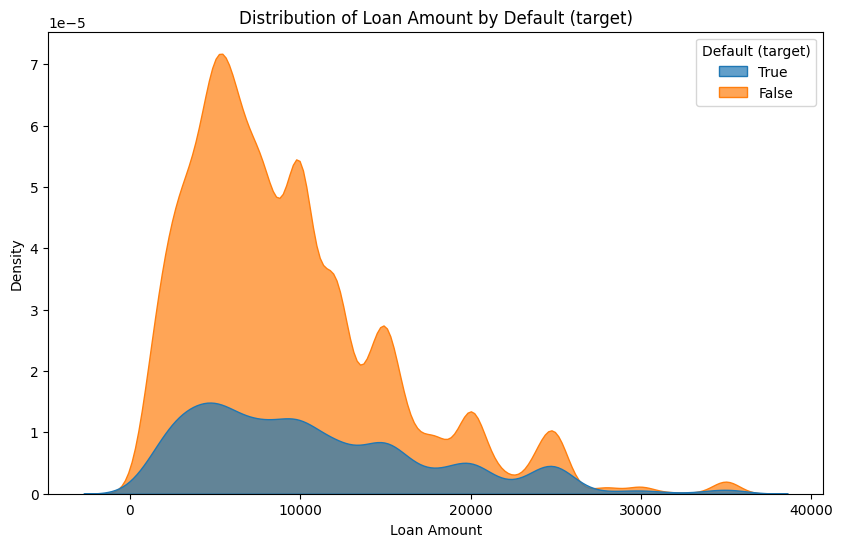

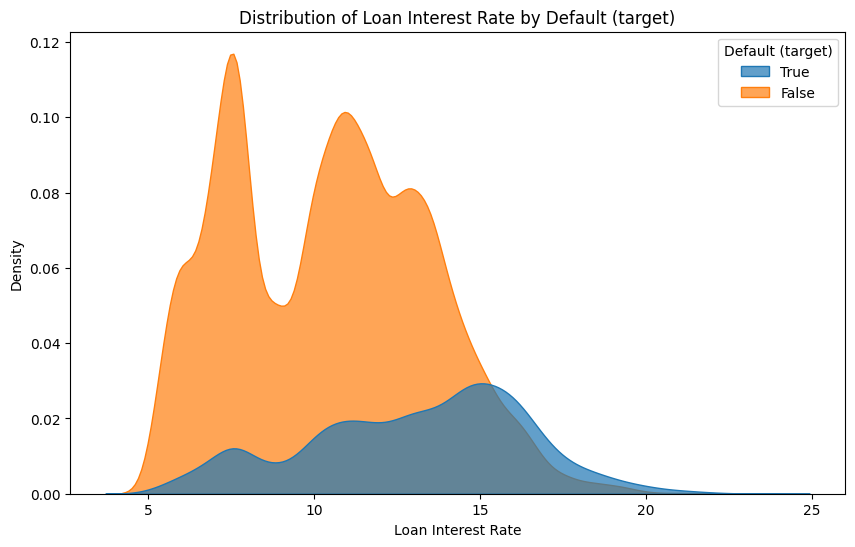

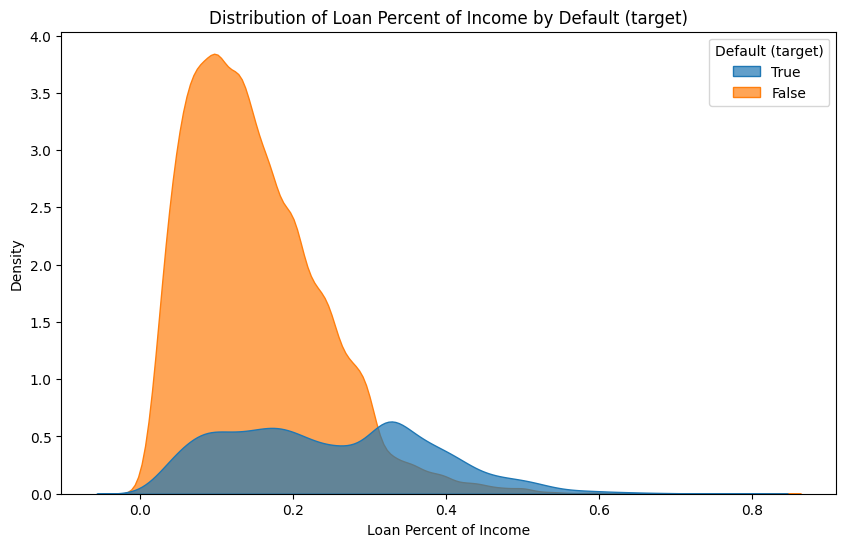

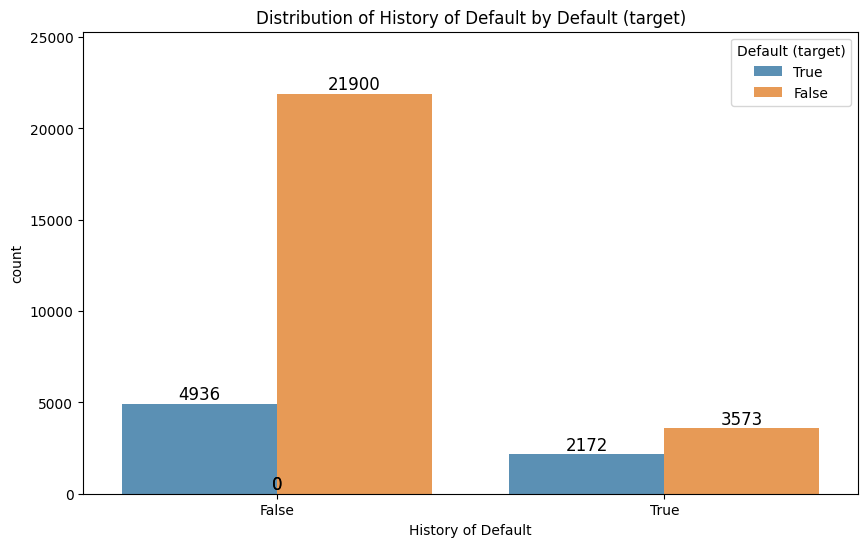

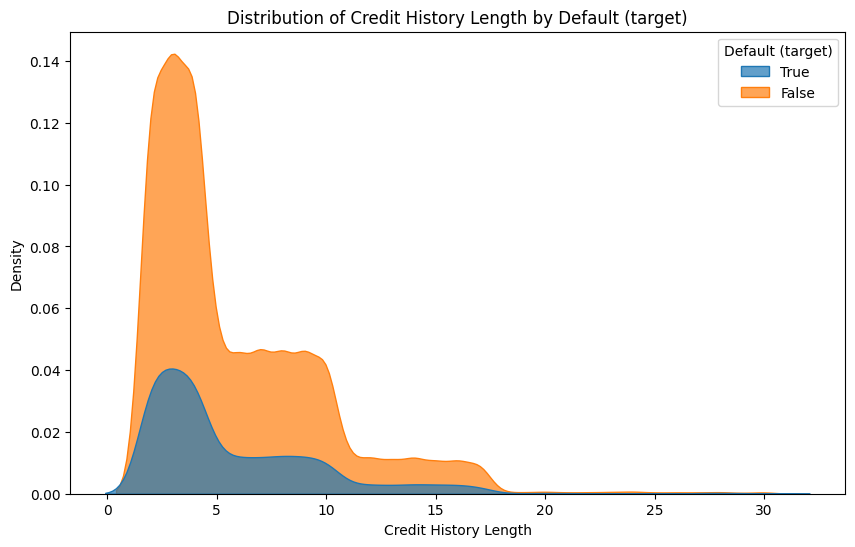

In [15]:
colors = {"True": "#1f77b4", "False": "#ff7f0e"} 
for column in df.columns.drop('Default (target)'):  # Exclude the target column from the plots
    plt.figure(figsize=(10, 6))
    plt.title(f'Distribution of {column} by Default (target)')

    # Check data type of the column
    if df[column].dtype in ['object', 'bool']:
        # For categorical and boolean data
        ax = sns.countplot(x=column, hue='Default (target)',alpha=0.8, hue_order = [True, False] ,data=df)
        # Add labels on top of each bar
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()),
                    fontsize=12, ha='center', va='bottom')

        # Adjust the y-axis limits to make space for the labels
        y_max = ax.get_ylim()[1]  
        ax.set_ylim(0, y_max * 1.1)  
        plt.show()
    else:
        # For continuous data
        sns.kdeplot(x=df[column],  fill=True, alpha=0.7, hue_order = [True, False], hue=df['Default (target)'])

    plt.show()

In [16]:
# creating a list of column names to differentiate categorical and continous based on data types
continuous_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['bool', 'object']).columns

# Pairwise Relationships/Associations Between Independent Variables

I will ran a series of univariate statistical tests to determine what relationships variables have with each other and what relationships variables potentially have a relationship with the dependent variable. When datasets are much larger, this is a great way to reduce the size of the data set and address concerns of multicollinearity, etc. 

## Using Pearson's Correlation to detect linear relationships between continuous variables

$$r_{xy} = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2 \sum_{i=1}^{n} (y_i - \bar{y})^2}}$$

Pearson's correlation measures how strongly and in what direction two continuous variables move together, assuming a linear relationship, either positively or negatively.

#### Assumptions for Pearson Correlation:

*(Note: Not all assumptions were tested in the code due to time constraints to deliver a TruStage technical project)* 

+ **Scale of Measurement:** Both variables should be continuous.
+ **Linearity:** The relationship between each pair of variables should be linear.
+ **No Outliers:** Outliers can significantly affect the result.
+ **Bivariate Normality:** Both variables should be approximately normally distributed.
+ **Homoscedasticity:** The variances along the line of best fit remain similar as you move along the line.

#### Interpreting the Pearson Correlation Coefficient:
+ -1 indicates a perfect negative linear relationship.
+ -0.7 to -0.999... indicates a strong negative linear relationship.
+ -0.3 to -0.699... indicates a moderate negative linear relationship.
+ -0.1 to -0.299... indicates a weak negative linear relationship.
+ 0 to -0.099... indicates no linear relationship.
+ 0.1 to 0.299... indicates a weak positive linear relationship.
+ 0.3 to 0.699... indicates a moderate positive linear relationship.
+ 0.7 to 0.999... indicates a strong positive linear relationship.
+ 1 indicates a perfect positive linear relationship.

,Age,Income,Years of Employment,Loan Amount,Loan Interest Rate,Loan Percent of Income,Credit History Length
Age,1.000000,0.141471,0.176054,0.056061,0.010370,-0.039476,0.877581
Income,0.141471,1.000000,0.160952,0.324766,-0.003767,-0.297635,0.122787
Years of Employment,0.176054,0.160952,1.000000,0.108390,-0.058263,-0.060099,0.151571
Loan Amount,0.056061,0.324766,0.108390,1.000000,0.145895,0.577197,0.045580
Loan Interest Rate,0.010370,-0.003767,-0.058263,0.145895,1.000000,0.123401,0.015330
Loan Percent of Income,-0.039476,-0.297635,-0.060099,0.577197,0.123401,1.000000,-0.029814
Credit History Length,0.877581,0.122787,0.151571,0.045580,0.015330,-0.029814,1.000000


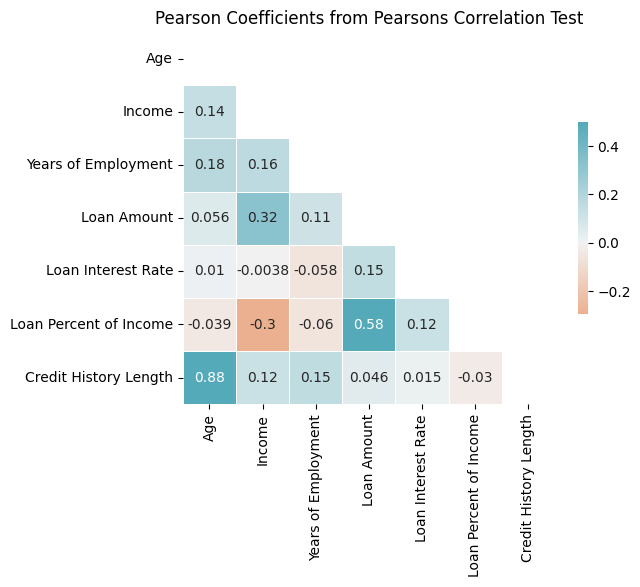

In [17]:
df_pearson = df.dropna()
df_continuouspearson = df_pearson[continuous_columns]

#Performing Pearson Correlation analysis
pearson_results = df_continuouspearson.corr('pearson')
display(pearson_results)

#Plotting the correlation matrix as a heatmap
mask = np.triu(np.ones_like(df_continuouspearson.corr('pearson'), dtype=bool))
f, ax = plt.subplots(figsize=(6, 5))
cmap = sns.diverging_palette(30, 210, l=65, center="light", as_cmap=True)
sns.heatmap(df_continuouspearson.corr('pearson'), mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.title('Pearson Coefficients from Pearsons Correlation Test')
plt.show()

# Define a function to interpret Pearson results
def interpret_pearson(r):
    if abs(r) == 1:
        return 'a perfect'
    elif abs(r) > 0.7:
        return 'a strong'
    elif abs(r) > 0.3:
        return 'a moderate'
    elif abs(r) > 0.1:
        return 'a weak'
    else:
        return 'no'

html_string = "<h4>Interpretation of Pearson's Correlation Test Results</h4><ul>"
# Flatten the correlation matrix and iterate
for (var1, var2), r in pearson_results.unstack().items():
    if var1 != var2:  # Exclude self-correlation
        strength = interpret_pearson(r)
        html_string += f"<li>{var1} and {var2} have {strength} relationship (Pearson's r: {r:.2f}).</li>"
html_string += "</ul>"
display(HTML(html_string))

## Using Spearman's Rank to detect non-linear relationships between continuous variables
$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

Spearman's correlation measures how strongly and in what direction two continuous variables move together, without assuming a linear relationship, either positively or negatively.

#### Assumptions for Spearman Correlation:

*(Note: Not all assumptions were tested in the code due to time constraints to deliver a TruStage technical project)* 

+ **Ordinal or Continuous Data:** Both variables should be continuous.
+ **Monotonic Relationship:** The relationship between variables should be either increasing or decreasing but not necessarily linear.
+ **No Tied Ranks:** Excessive ties can reduce the power of the test.
+ **No Outliers:** Outliers should be checked as they can affect the correlation.

#### Interpreting the Spearman Correlation Coefficient:
+ -1 indicates a perfect negative monotonic relationship.
+ -0.7 to -0.999... indicates a strong negative monotonic relationship.
+ -0.3 to -0.699... indicates a moderate negative monotonic relationship.
+ -0.1 to -0.299... indicates a weak negative monotonic relationship.
+ 0 to -0.099... indicates no monotonic relationship.
+ 0.1 to 0.299... indicates a weak positive monotonic relationship.
+ 0.3 to 0.699... indicates a moderate positive monotonic relationship.
+ 0.7 to 0.999... indicates a strong positive monotonic relationship.
+ 1 indicates a perfect positive monotonic relationship.

,Age,Income,Years of Employment,Loan Amount,Loan Interest Rate,Loan Percent of Income,Credit History Length
Age,1.000000,0.146138,0.106560,0.067033,0.009944,-0.055415,0.805339
Income,0.146138,1.000000,0.213341,0.403579,-0.038808,-0.362315,0.094480
Years of Employment,0.106560,0.213341,1.000000,0.108032,-0.066491,-0.060004,0.070043
Loan Amount,0.067033,0.403579,0.108032,1.000000,0.105392,0.660082,0.045797
Loan Interest Rate,0.009944,-0.038808,-0.066491,0.105392,1.000000,0.126589,0.013063
Loan Percent of Income,-0.055415,-0.362315,-0.060004,0.660082,0.126589,1.000000,-0.033944
Credit History Length,0.805339,0.094480,0.070043,0.045797,0.013063,-0.033944,1.000000


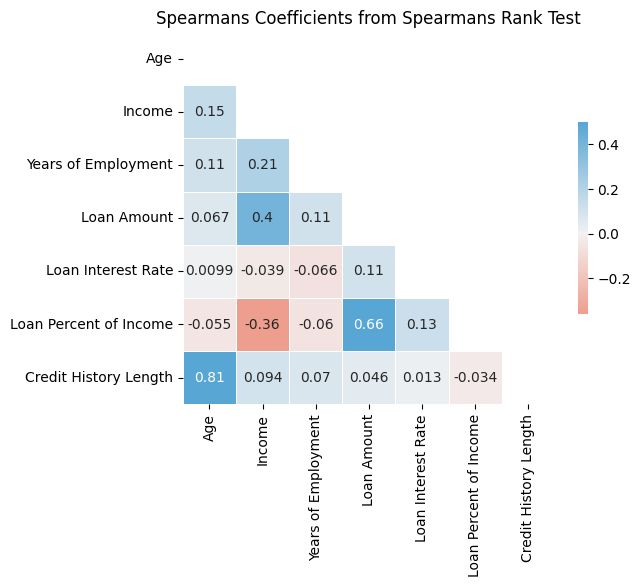

In [18]:
df_spearman = df.dropna()
df_continuousspearman = df_spearman[continuous_columns]

# Performing the spearman correlation analysis
spearman_results = df_continuousspearman.corr('spearman')
display(spearman_results)

# Plotting the spearman correlation matrix as a heatmap
mask = np.triu(np.ones_like(df_continuousspearman.corr('spearman'), dtype=bool))
f, ax = plt.subplots(figsize=(6, 5))
cmap = sns.diverging_palette(20, 235, l=65, center="light", as_cmap=True)
sns.heatmap(df_continuousspearman.corr('spearman'), mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.title('Spearmans Coefficients from Spearmans Rank Test')
plt.show()

# Define a function to interpret Spearman results
def interpret_spearman(rho):
    if abs(rho) == 1:
        return 'a perfect'
    elif abs(rho) > 0.7:
        return 'a strong'
    elif abs(rho) > 0.3:
        return 'a moderate'
    elif abs(rho) > 0.1:
        return 'a weak'
    else:
        return 'no'

html_string = "<h4>Interpretation of Spearman's Rank Correlation Test Results</h4><ul>"
# Flatten the correlation matrix and iterate
for (var1, var2), rho in spearman_results.unstack().items():
    if var1 != var2:  # Exclude self-correlation
        strength = interpret_spearman(rho)
        html_string += f"<li>{var1} and {var2} have {strength} monotonic relationship (Spearman's rho: {rho:.2f}).</li>"
html_string += "</ul>"
display(HTML(html_string))

## Using Chi-Squared to detect relationships between categorical variables
$$
\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}
$$

The Chi-squared test evaluates whether there is a significant association between two categorical variables, indicating if they move together or independently.

#### Assumptions for Chi-Squared Test:
*(Note: Not all assumptions were tested in the code due to time constraints to deliver a TruStage technical project)*  

+ **Categorical Data:** Both variables being analyzed should be categorical.
+ **Independence of Observations:** Each observation should be independent of the others. The outcome of one observation should not influence another.

#### Interpreting Chi-Squared Test Scores:

+ **High Chi-Squared Statistic and Low P-value (usually below 0.05):** Indicates a significant association between the two categorical variables. There's evidence that the variables are related and not independent of each other.
+ **Low Chi-Squared Statistic or High P-value (usually above 0.05):** Indicates no significant association between the variables. This implies the variables are independent of each other.

,Y,X,Chi-squared,P-value,Degrees of Freedom
2,Home Ownership,Default (target),1907.980698,0.000000e+00,3
7,Loan Grade,Default (target),5609.184187,0.000000e+00,6
8,Loan Grade,History of Default,13053.044593,0.000000e+00,6
9,Default (target),History of Default,1044.439595,3.934660e-229,1
0,Home Ownership,Loan Intent,760.872110,1.931448e-152,15
1,Home Ownership,Loan Grade,743.432477,3.398469e-146,18
5,Loan Intent,Default (target),520.511561,2.980682e-110,5
3,Home Ownership,History of Default,139.440269,4.990525e-30,3
4,Loan Intent,Loan Grade,78.469826,3.271001e-06,30


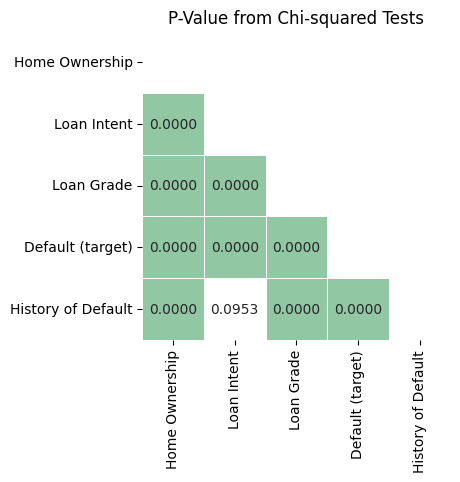

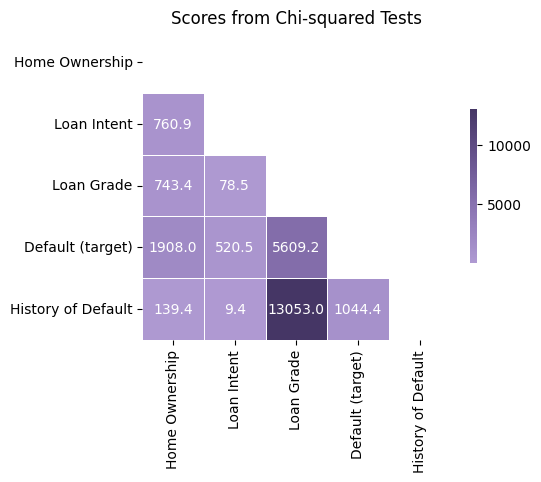

In [19]:
results = []
df_chi = df.dropna()
df_categorical_chi = df[categorical_columns]
# Iterate over all pairs of categorical variables to calculate Chi Squared scores
for a, b in combinations(df_categorical_chi.columns, 2):
    contingency_table = pd.crosstab(df_categorical_chi[a], df_categorical_chi[b])
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    results.append((a, b, chi2, p, dof))
results_df = pd.DataFrame(results, columns=['Y', 'X', 'Chi-squared', 'P-value', 'Degrees of Freedom'])
adjusted_alpha = 0.05 / len(results)
results_df['Significant at 0.05'] = results_df['P-value'] < adjusted_alpha

# Sort the DataFrame by Chi Squared scores in descending order to prioritize significant relationships
chisquared_results = results_df.sort_values(by=['P-value'], ascending=True)
display(chisquared_results[chisquared_results['Significant at 0.05']==True].drop('Significant at 0.05',axis = 1))
score_matrix = pd.DataFrame(np.nan, 
                            index=df_categorical_chi.columns, 
                            columns=df_categorical_chi.columns)

for _, row in chisquared_results.iterrows():
    score_matrix.loc[row['Y'], row['X']] = row['P-value']
    score_matrix.loc[row['X'], row['Y']] = row['P-value']  # Assuming symmetry
cmap=sns.cubehelix_palette(start=2, 
                           rot=0.03, 
                           dark=0.7, 
                           light=3,
                           as_cmap=True, 
                           reverse=True)
plt.figure(figsize=(5, 4))
mask = np.triu(np.ones_like(score_matrix, dtype=bool))
sns.heatmap(score_matrix, 
            annot=True, 
            cmap=cmap, 
            fmt='.4f', 
            mask=mask,
            square=True, 
            linewidths=.5, 
            cbar=False)
plt.title('P-Value from Chi-squared Tests')
plt.show()

score_matrix = pd.DataFrame(np.nan, index=df_categorical_chi.columns, columns=df_categorical_chi.columns)
for _, row in chisquared_results.iterrows():
    score_matrix.loc[row['Y'], row['X']] = row['Chi-squared']
    score_matrix.loc[row['X'], row['Y']] = row['Chi-squared']
cmap = LinearSegmentedColormap.from_list("reversed", 
                                         list(reversed(sns.cubehelix_palette(start=.1, 
                                                                             rot=.02, 
                                                                             dark=.65, 
                                                                             light=.25, 
                                                                             as_cmap=False))))
plt.figure(figsize=(5, 4))
mask = np.triu(np.ones_like(score_matrix, dtype=bool))
sns.heatmap(score_matrix, 
            annot=True, 
            cmap=cmap, 
            fmt='.1f', 
            mask=mask,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
plt.title('Scores from Chi-squared Tests')
plt.show()

# Define a function to interpret Chi-Squared results
def interpret_chi_squared(p_value, chi_squared_stat, adjusted_alpha):
    if p_value <= adjusted_alpha:
        return f'a significant association (Chi-Squared Statistic: {chi_squared_stat:.2f}, P-value: {p_value:.4f})'
    else:
        return 'no significant association'

# Adjust the alpha level for multiple comparisons (Bonferroni correction method to avoid Type 1 Error)
adjusted_alpha = 0.05 / len(chisquared_results)

# Sort the Chi-Squared results by Chi-Squared Statistic in descending order
sorted_chi_squared_results = chisquared_results.sort_values(by='Chi-squared', ascending=False)

html_string = "<h4>Interpretation of Chi-Squared Test's Results (Sorted by Chi-Squared Statistic)</h4><ul>"
for _, row in sorted_chi_squared_results.iterrows():
    association = interpret_chi_squared(row['P-value'], row['Chi-squared'], adjusted_alpha)
    var1 = row['Y']
    var2 = row['X']
    html_string += f"<li>Between {var1} and {var2}, there is {association}.</li>"
html_string += "</ul>"
display(HTML(html_string))

# Iterating through the Chi-Squared results
for _, row in sorted_chi_squared_results.iterrows():
    if row['Y'] == 'Default (target)' or row['X'] == 'Default (target)':
        association = interpret_chi_squared(row['P-value'], row['Chi-squared'], adjusted_alpha)
        if association != 'no significant association':
            relevant_features_list.append(row['Y'] if row['Y'] != 'Default (target)' else row['X'])

# Removing duplicates from the list
relevant_features_list = list(set(relevant_features_list))

## Using Mutual Information to detect associations between categorical variables
$$
I(X; Y) = \sum_{y \in Y} \sum_{x \in X} p(x, y) \log \left( \frac{p(x, y)}{p(x) p(y)} \right)
$$

Mutual information measures how much two categorical variables are related in terms of the shared information they carry.

#### Assumptions for Mutual Information:
*(Note: Not all assumptions were tested in the code due to constraints in the Pfizer interview project)* 

+ **Categorical Data:** Both variables being analyzed should be categorical. If one is continuous, it needs to be made categorical/discrete.
+ **Independence of Observations:** Each observation should be independent of the others. Each pair of data points should not influence each other.
+ **No Hidden Variables:** The analysis assumes that all relevant variables are included. Hidden or unobserved variables can affect the accuracy of MI.

#### Interpreting Mutual Information Scores:

+ **High MI Score:** Indicates a strong relationship between the two variables. A high score means that knowing the value of one variable gives a lot of information about the value of the other.
+ **Moderate MI Score:** Indicates a moderate relationship. Some information about one variable can be inferred by knowing the value of the other, but there are uncertainties.
+ **Low MI Score:** Indicates a weak or no relationship. Knowing the value of one variable gives little to no information about the other.

,Y,X,Mutual Information
8,Loan Grade,History of Default,0.224378
7,Loan Grade,Default (target),0.074487
2,Home Ownership,Default (target),0.030677
9,Default (target),History of Default,0.014507
0,Home Ownership,Loan Intent,0.013290
1,Home Ownership,Loan Grade,0.011407
5,Loan Intent,Default (target),0.008076
3,Home Ownership,History of Default,0.002150
4,Loan Intent,Loan Grade,0.001177
6,Loan Intent,History of Default,0.000141


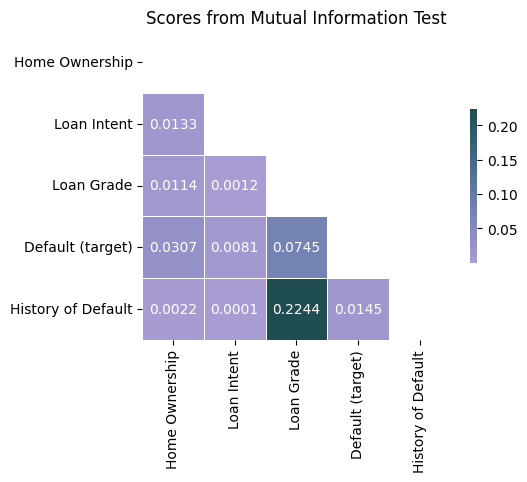

In [20]:
results = []
df_categorical_for_mi = df[categorical_columns].dropna() #drop missing columns so we are only looking at relationships of complete data

# Iterate over all pairs of categorical variables to calculate mutual information scores
for a, b in combinations(df_categorical_for_mi.columns, 2):
    mi_score = mutual_info_score(df_categorical_for_mi[a], df_categorical_for_mi[b])
    results.append((a, b, mi_score))
results_df = pd.DataFrame(results, columns=['Y', 'X', 'Mutual Information'])

# Sort the DataFrame by mutual information scores in descending order to prioritize stronger relationships
mi_results = results_df.sort_values(by=['Mutual Information'], ascending=False)
display(mi_results)

score_matrix = pd.DataFrame(np.nan, index=df_categorical_for_mi.columns, columns=df_categorical_for_mi.columns)
# Populate the matrix with mutual information scores, ensuring symmetry by filling both [Y,X] and [X,Y] positions
for _, row in mi_results.iterrows():
    score_matrix.loc[row['Y'], row['X']] = row['Mutual Information']
    score_matrix.loc[row['X'], row['Y']] = row['Mutual Information']
cmap = LinearSegmentedColormap.from_list("reversed", 
                                         list(reversed(sns.cubehelix_palette(start=-0.9, 
                                                                             rot=.5, 
                                                                             dark=0.65, 
                                                                             light=0.25, 
                                                                             as_cmap=False))))
plt.figure(figsize=(5, 4))
mask = np.triu(np.ones_like(score_matrix, dtype=bool))
sns.heatmap(score_matrix, 
            annot=True, 
            cmap=cmap, 
            fmt='.4f', 
            mask=mask,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
plt.title('Scores from Mutual Information Test')
plt.show()

# Scaling the Mutual Information scores
mi_values = np.array(mi_results['Mutual Information']).reshape(-1, 1)
scaler = MinMaxScaler()
scaled_scores = scaler.fit_transform(mi_values)

# Add the scaled scores to the DataFrame
mi_results['Scaled MI'] = scaled_scores

# Define a function to categorize scaled MI scores
#def categorize_mi(scaled_mi):
#    if scaled_mi > 0.6667:
#        return 'a high'
#    elif scaled_mi > 0.333:
#        return 'a moderate'
#    else:
#        return 'a low'

# Define a function to categorize scaled MI scores and check for relevance to target'
def categorize_mi_and_check_relevance(row):
    if row['Scaled MI'] > 0.6667:
        category = 'a high'
    elif row['Scaled MI'] > 0.333:
        category = 'a moderate'
    else:
        category = 'a low'
    return category   
    
# Sorting the results by Scaled Mutual Information in descending order
sorted_mi_results = mi_results.sort_values(by='Scaled MI', ascending=False)

html_string = "<h4>Interpretation of Mutual Information Scores (Relative to Maximum and Minimum Scores) </h4><ul>"
for _, row in sorted_mi_results.iterrows():
    category = categorize_mi_and_check_relevance(row)
    if category != 'a low':  # Only append if category is 'high' or 'moderate'
        var1 = row['Y']
        var2 = row['X']
        mi_score = row['Mutual Information']
        html_string += f"<li>{var1} and {var2} have {category} relationship (MI Score: {mi_score:.4f}).</li>"
        relevant_features_list.append(var1 if var1 != 'Default (target)' else var2)

html_string += "</ul>"
display(HTML(html_string))
relevant_features_list = list(set(relevant_features_list))

## Using ANOVA correlation to detect linear relationships between categorical and continuous variables

$$
\eta^2 = \frac{SS_{\text{between}}}{SS_{\text{total}}}
$$

The ANOVA correlation coefficient (F-value) is used to identify linear relationships between categorical and continuous variables by comparing the means of different groups (defined by the categorical variable) and determining if there are significant differences in the continuous variable across these groups.

#### Assumptions:
*(Note: Not all assumptions were tested in the code due to time constraints to deliver a TruStage technical project)* 

+ **Independent Groups:** Each group, defined by the categorical variable, should be independent of the others. Think of it as comparing separate teams or categories without overlap.
+ **Normality Within Each Group (Small Datasets):** The continuous variable should approximately follow a normal distribution within each group. This is like saying the data should spread out in a bell-shaped curve in each category.
+ **Homogeneity of Variances:** The spread (variance) of the continuous variable should be similar across all groups. Imagine each category having similar variability or range in their data.
+ **Sample Size:** Ideally, each group should have a reasonably large number of observations. The larger the sample, the more reliable the results.
+ **Random Sampling:** The data should be collected randomly. This means every member of the population has an equal chance of being included in the study.

#### Interpreting ANOVA Scores:

- **High F-Score and Low P-value (usually below 0.05):** Indicates that there's a significant difference between groups. ANOVA indicates that there's a difference, but not where it is.

- **Low F-Score or High P-value (usually above 0.05):** Indicates that groups are not that different from each other in terms of the variable being testing.

,Y (Categorical Variable),X (Continuous Variable),F-value,P-value
18,Loan Grade,Loan Interest Rate,44316.098421,0.000000e+00
32,History of Default,Loan Interest Rate,9555.220836,0.000000e+00
26,Default (target),Loan Percent of Income,4818.050339,0.000000e+00
25,Default (target),Loan Interest Rate,3725.015674,0.000000e+00
22,Default (target),Income,821.657201,3.482742e-178
2,Home Ownership,Years of Employment,603.700079,0.000000e+00
1,Home Ownership,Income,584.506933,0.000000e+00
24,Default (target),Loan Amount,372.715922,1.606765e-82
23,Default (target),Years of Employment,215.762753,1.142787e-48
5,Home Ownership,Loan Percent of Income,205.469071,7.286113e-132


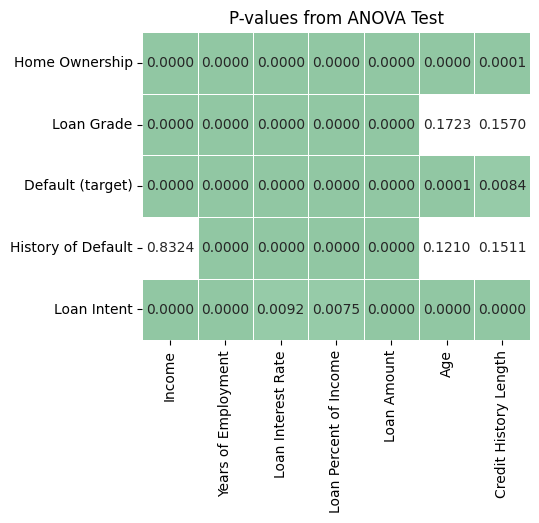

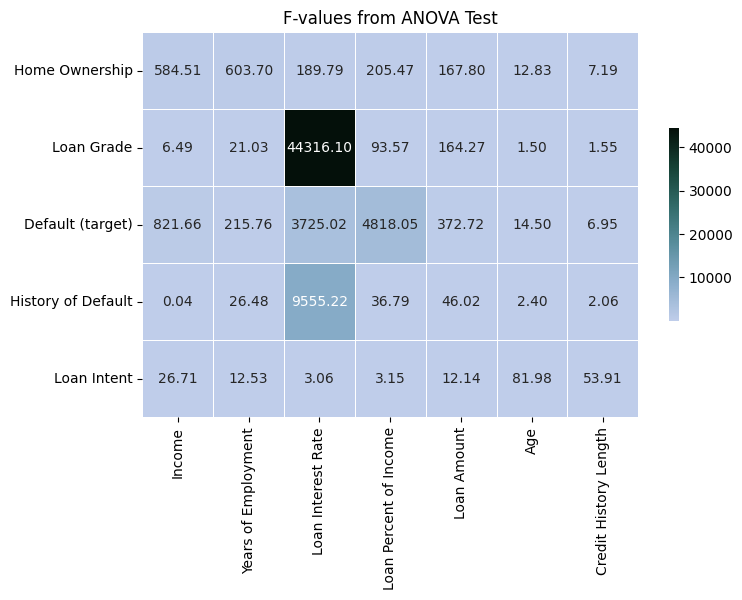

In [21]:
results = []
df_anova = df.dropna()

# Separate the continuous and categorical columns
df_continuous_anova = df_anova[continuous_columns]
df_categorical_anova = df_anova[categorical_columns]

# Perform ANOVA tests between each categorical and continuous variable pair
for cat_col in df_categorical_anova.columns:
    for cont_col in df_continuous_anova.columns:
        grouped_data = df_continuous_anova[cont_col].groupby(df_categorical_anova[cat_col])
        groups = [group for _, group in grouped_data]
        f_value, p_value = stats.f_oneway(*groups)
        results.append({
            'Y (Categorical Variable)': cat_col,
            'X (Continuous Variable)': cont_col,
            'F-value': f_value,
            'P-value': p_value
        })
# Convert the results into a DataFrame and sort by P-value
results = pd.DataFrame(results)
anova_results = results.sort_values(by=['P-value'], ascending=True)
anova_results['Significant at 0.05'] = anova_results['P-value'] < adjusted_alpha

# Display significant ANOVA results sorted by F-value
display(anova_results[anova_results['Significant at 0.05']==True].sort_values(by=['F-value'], ascending=False).drop('Significant at 0.05',axis = 1))

# Create a matrix to visualize P-values between each categorical and continuous variable pair
score_matrix = pd.DataFrame(np.nan, index=df_continuous_anova.columns, columns=df_categorical_anova.columns)
for _, row in anova_results.iterrows():
    score_matrix.loc[row['Y (Categorical Variable)'], row['X (Continuous Variable)']] = row['P-value']
score_matrix = score_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')
cmap=sns.cubehelix_palette(start=2, 
                           rot=0.03, 
                           dark=0.7, 
                           light=3,
                           as_cmap=True, 
                           reverse=True)

# Plot the P-value matrix as a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(score_matrix, 
            annot=True, 
            cmap=cmap, 
            fmt='.4f',
            square=False, 
            linewidths=.5, 
            cbar=False)
plt.title('P-values from ANOVA Test')
plt.show()

# Create a matrix to visualize F-values between each categorical and continuous variable pair
score_matrix = pd.DataFrame(np.nan, index=df_continuous_anova.columns, columns=df_categorical_anova.columns)
for _, row in anova_results.iterrows():
    score_matrix.loc[row['Y (Categorical Variable)'], row['X (Continuous Variable)']] = row['F-value']
score_matrix = score_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')
cmap = LinearSegmentedColormap.from_list("reversed", 
                                         list(reversed(sns.cubehelix_palette(start=-0.9, 
                                                                             rot=.3, 
                                                                             dark=.8, 
                                                                             light=0.05, 
                                                                             as_cmap=False))))

# Plot the F-value matrix as a heatmap                                                                             as_cmap=False))))
plt.figure(figsize=(8, 5))
sns.heatmap(score_matrix, 
            annot=True, 
            cmap=cmap, 
            fmt='.2f',
            square=False, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
plt.title('F-values from ANOVA Test')
plt.show()

# Define a function to interpret ANOVA results
def interpret_anova(p_value, f_value):
    if p_value <= adjusted_alpha:
        return f'a significant difference (F-Score: {f_value:.2f})'
    else:
        return 'no significant difference'

# Sort the ANOVA results by F-Score in descending order
sorted_anova_results = anova_results.sort_values(by='F-value', ascending=False)

html_string = "<h4>Interpretation of ANOVA Test's Results (Sorted by F-Score)</h4><ul>"
for _, row in sorted_anova_results.iterrows():
    difference = interpret_anova(row['P-value'], row['F-value'])
    cat_var = row['Y (Categorical Variable)']
    cont_var = row['X (Continuous Variable)']
    html_string += f"<li>Between the groups of {cat_var}, there is {difference} in {cont_var}.</li>"
html_string += "</ul>"
display(HTML(html_string))

# Iterating through the ANOVA results
for _, row in sorted_anova_results.iterrows():
    if row['Y (Categorical Variable)'] == 'Default (target)':
        significance = interpret_anova(row['P-value'], row['F-value'])
        if significance != 'no significant difference':
            relevant_features_list.append(row['X (Continuous Variable)'])

# Removing duplicates from the list
relevant_features_list = list(set(relevant_features_list))

## Using Kendall's Rank correlation to detect non-linear relationships between ordinal categorical and continuous variables

$$
\tau = \frac{2}{n(n-1)} \sum_{i < j} \text{sgn}(x_i - x_j) \cdot \text{sgn}(y_i - y_j)
$$

Kendall's Tau measures the strength and direction of association between ordinal variables and continuous variables, ranking their values and assessing how similarly the values are ordered.

#### Assumptions: 

*(Note: Not all assumptions were tested in the code due to time constraints to deliver a TruStage technical project)* 


+ **Ordinal or Continuous Data:** One variable should be able to be ranked, and the other can also be ranked or be a continuous variable.
+ **Mutually Exclusive Observations:** Each pair you're comparing should not affect other pairs.
+ **No Outliers:** Extreme values that don't fit the general pattern should be checked, as they can skew the results.
+ **No Assumptions of Normality:** This test doesn't need your data to follow a specific 'normal' pattern, making it versatile.
+ **Bivariate Relationship:** The test only looks at two variables at a time and doesn't consider the influence of any other factors.

#### Interpreting the Kendall's Tau score: 
+ -1 shows a perfect indirect relationship
+ -0.5 to -0.999... shows a strong, indirect relationship
+ -0.3 to -0.499... shows a moderate, indirect relationship
+ -0.1 to -0.299... shows a weak, indirect relationship
+ -0.099... to 0.099... shows no noteworthy relationship
+ 0.1 to 0.299... shows a weak, direct relationship
+ 0.3 to 0.499... shows a moderate, direct relationship
+ 0.5 to 0.999... shows a strong, direct relationship
+ 1 shows a perfect direct relationship

,Y (Categorical Variable),X (Continuous Variable),Kendall Tau,P-value
4,Loan Grade,Loan Interest Rate,0.838268,0.000000e+00
5,Loan Grade,Loan Percent of Income,0.094586,4.452588e-99
3,Loan Grade,Loan Amount,0.078375,8.682979e-69
2,Loan Grade,Years of Employment,-0.049486,4.753711e-27
1,Loan Grade,Income,-0.029814,1.632094e-11
6,Loan Grade,Credit History Length,0.009278,4.639043e-02


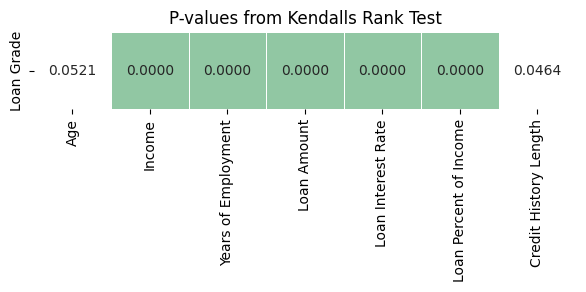

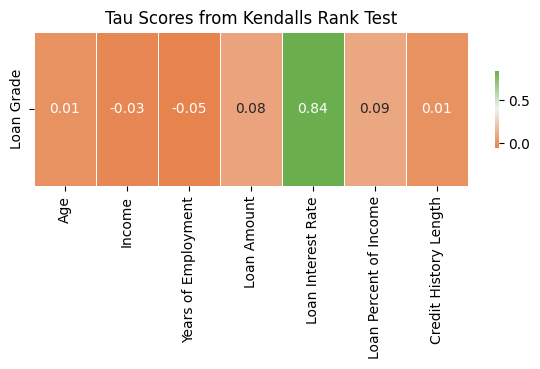

In [22]:
# dropping any nulls since we are only measuring complete data
df_kendallstau = df.dropna()
df_continuous_kendallstau = df_kendallstau[continuous_columns]
df_categorical_kendallstau = df_kendallstau[categorical_columns]

# Filter columns based on whether they contain strings starting with a number
ordinal_columns = [col for col in df_categorical_kendallstau.columns 
                   if any(re.match(r'^\d', str(x)) for x in df_categorical_kendallstau[col].dropna())]
df_categorical_kendallstau = df_categorical_kendallstau[ordinal_columns]


# Calculate Kendall Tau correlations
results = []
for cat_col in df_categorical_kendallstau.columns:
    for cont_col in df_continuous_kendallstau.columns:
        tau, p_value = kendalltau(df_categorical_kendallstau[cat_col], df_continuous_kendallstau[cont_col])
        results.append({
            'Y (Categorical Variable)': cat_col,
            'X (Continuous Variable)': cont_col,
            'Kendall Tau': tau,
            'P-value': p_value
        })

adjusted_alpha = 0.05  # adjust p-value threshold as needed

kendall_results = pd.DataFrame(results)
kendall_results['Significant at 0.05'] = kendall_results['P-value'] <= adjusted_alpha

# Sorting and displaying the significant results
tau_results = kendall_results[kendall_results['Significant at 0.05']].sort_values(by='P-value').drop('Significant at 0.05', axis=1)
display(tau_results)

# Heatmap for P-values
score_matrix = pd.DataFrame(np.nan, index=df_continuous_kendallstau.columns, columns=df_categorical_kendallstau.columns)
for _, row in kendall_results.iterrows():
    score_matrix.loc[row['Y (Categorical Variable)'], row['X (Continuous Variable)']] = row['P-value']
score_matrix = score_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')
cmap=sns.cubehelix_palette(start=2, rot=0.03, dark=0.7, light=3, as_cmap=True, reverse=True)
plt.figure(figsize=(7, 1))
sns.heatmap(score_matrix, annot=True, cmap=cmap, fmt='.4f',square=False, linewidths=.5, cbar=False)
plt.title('P-values from Kendalls Rank Test')
plt.show()

# Heatmap for the Tau scores
score_matrix = pd.DataFrame(np.nan, index=df_continuous_kendallstau.columns, columns=df_categorical_kendallstau.columns)
for _, row in kendall_results.iterrows():
    score_matrix.loc[row['Y (Categorical Variable)'], row['X (Continuous Variable)']] = row['Kendall Tau']
score_matrix = score_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')
cmap = sns.diverging_palette(30, 1200, l=65, center="light", as_cmap=True)
plt.figure(figsize=(7, 2))
sns.heatmap(score_matrix, annot=True, cmap=cmap, fmt='.2f',square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Tau Scores from Kendalls Rank Test')
plt.show()

# Define a function to categorize tau
def categorize_tau(tau, p):
    if p <= adjusted_alpha:
        if tau == -1:
            return 'a perfect,', 'indirect'
        elif -1 < tau <= -0.5:
            return 'a strong,', 'indirect'
        elif -0.5 < tau <= -0.3:
            return 'a moderate,', 'indirect'
        elif -0.3 < tau <= -0.1:
            return 'a weak,', 'indirect'
        elif -0.1 < tau < 0.1:
            return 'no', ''
        elif 0.1 <= tau < 0.3:
            return 'a weak,', 'direct'
        elif 0.3 <= tau < 0.5:
            return 'a moderate,', 'direct'
        elif 0.5 <= tau < 1:
            return 'a strong,', 'direct'
        elif tau == 1:
            return 'a perfect,', 'direct'
    else: pass
html_string = "<h4>Interpretation of Kendall's Rank test's significant results</h4><ul>"
for _, row in tau_results.iterrows():
    strength, direction = categorize_tau(row['Kendall Tau'], row['P-value'])
    var1 = row['Y (Categorical Variable)']
    var2 = row['X (Continuous Variable)']
    html_string += f"<li>{var1} and {var2} have {strength} {direction} relationship.</li>"
html_string += "</ul>"
display(HTML(html_string))

# Define a function to categorize tau and check significance
def categorize_and_check_significance(tau, p):
    if p <= adjusted_alpha:
        if abs(tau) == 1:
            return 'perfect'
        elif 0.5 <= abs(tau) < 1:
            return 'strong'
        elif 0.3 <= abs(tau) < 0.5:
            return 'moderate'
    return None

# Iterating through the Kendall Tau results
for _, row in tau_results.iterrows():
    if row['Y (Categorical Variable)'] == 'Default (target)' or row['X (Continuous Variable)'] == 'Default (target)':
        significance = categorize_and_check_significance(row['Kendall Tau'], row['P-value'])
        if significance in ['moderate', 'strong', 'perfect']:
            relevant_features_list.append(row['Y (Categorical Variable)'] if row['Y (Categorical Variable)'] != 'Default (target)' else row['X (Continuous Variable)'])

# Removing duplicates from the list
relevant_features_list = list(set(relevant_features_list))

# Feature Engineering
## Feature Selection and Imputing Missing Data
(Note: I typically impute missing values after conducting an Exploratory Data Analysis (EDA), whenever feasible. This approach can vary depending on the extent of missing data. In this instance, the dataset contained sufficient complete data to facilitate an understanding without the need for imputation. For the purposes of modeling, imputation precedes variable encoding, although this sequence may not be strictly adhered to in every case. Adjustments to this process are made at my discretion, depending on the specific characteristics of the data at hand. Following the Exploratory Data Analysis (EDA), I proceeded with imputation using KNN, despite the initial assessment of the data.)

I utilized Univariate statistical tests (above in the EDA) to identify features that exhibit a relationship with the dependent variable. Below, you'll find the list of selected features. In projects that are more complex and extended, this process often requires greater detail and attention. The goal is to achieve a balance that aids in minimizing data drift, thereby reducing the likelihood of the model becoming outdated prematurely.

In [23]:
pd.DataFrame(relevant_features_list, columns = ['Selected Features From Univariate Statistical Tests'])

,Selected Features From Univariate Statistical Tests
0,Loan Amount
1,Loan Grade
2,History of Default
3,Home Ownership
4,Loan Intent
5,Age
6,Years of Employment
7,Loan Interest Rate
8,Loan Percent of Income
9,Income


### Handling Missing Data and Encoding
If the dataset exhibits a missing data percentage ranging from 10 to 60%, I treat and model this subset of data separately. Conversely, for datasets with less than 10% missing data, I employ imputation techniques using KNN or statistical measures such as means, modes, or medians, selecting the method that best aligns with the distribution of the data. Also this is where I encoded the categorical variables.

In [24]:
relevant_features_list.append('Default (target)')
df_data = df[relevant_features_list]

# This function below would typically be split into a series of functions as it does too much, but for this project: 
# process_missing_data determines if columns need to be dropped based on the amount of missing data.
# If the data has between 10 to 60% missing data, then the data is modeled separately. 
# If the data is below 10% missing data, then the data is imputed using KNN or statistical means, modes, medians based on distributions.
# This function also encodes the categorical variables. 
def process_missing_data(df):
    missing_percent = df.isnull().mean()

    # Dropping columns with more than 60% missing data
    columns_to_drop = missing_percent[missing_percent > 0.6].index
    df_dropped = df.drop(columns=columns_to_drop)

    # Handling columns with 10% to 60% missing data
    columns_to_split = missing_percent[(missing_percent > 0.1) & (missing_percent <= 0.6)].index
    dfs_with_missing = {}
    dfs_without_missing = {}

    for col in columns_to_split:
        dfs_with_missing[col] = df_dropped[df_dropped[col].isnull()]
        dfs_without_missing[col] = df_dropped[df_dropped[col].notnull()]

    # Removing the split columns from the original DataFrame for imputation
    df_for_imputation = df_dropped.drop(columns=columns_to_split)

    # Encoding categorical variables
    df_for_imputation_encoded = pd.get_dummies(df_for_imputation)

    # Applying KNN imputation for remaining columns
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = pd.DataFrame(imputer.fit_transform(df_for_imputation_encoded), columns=df_for_imputation_encoded.columns)

    # Constructing the output dictionary
    output_dict = {
        "final_df": df_imputed,
        "dfs_with_missing": dfs_with_missing,
        "dfs_without_missing": dfs_without_missing
        # final_df: DataFrame after KNN imputation
        # dfs_with_missing: Dictionary of DataFrames where each key is a column name, and value is DataFrame with missing values in that column
        # dfs_without_missing: Dictionary of DataFrames where each key is a column name, and value is DataFrame without missing values in that column
    }
    return output_dict

Volume of missing data per column **before** handling missing data: 

In [25]:
pd.DataFrame(df_data.isnull().sum(), columns = ['Nulls'])

,Nulls
Loan Amount,0
Loan Grade,0
History of Default,0
Home Ownership,0
Loan Intent,0
Age,5
Years of Employment,902
Loan Interest Rate,3116
Loan Percent of Income,0
Income,0


Dataframe(s) after imputation: 

In [26]:
output = process_missing_data(df_data) # runs the function to handle missing data and encode categorical variables 
df_modeling_data = next(iter(output.values())) #shows the tables (in this case there is only 1)
df_modeling_data

,Loan Amount,History of Default,Age,Years of Employment,Loan Interest Rate,Loan Percent of Income,Income,Default (target),Loan Grade_1) A,Loan Grade_2) B,...,Home Ownership_MORTGAGE,Home Ownership_OTHER,Home Ownership_OWN,Home Ownership_RENT,Loan Intent_DEBTCONSOLIDATION,Loan Intent_EDUCATION,Loan Intent_HOMEIMPROVEMENT,Loan Intent_MEDICAL,Loan Intent_PERSONAL,Loan Intent_VENTURE
0,35000.0,1.0,22.0,6.0,16.02,0.59,59000.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1000.0,0.0,21.0,5.0,11.14,0.10,9600.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,5500.0,0.0,25.0,1.0,12.87,0.57,9600.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,35000.0,0.0,23.0,4.0,15.23,0.53,65500.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,35000.0,1.0,24.0,8.0,14.27,0.55,54400.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,5800.0,0.0,57.0,1.0,13.16,0.11,53000.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32577,17625.0,0.0,54.0,4.0,7.49,0.15,120000.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32578,35000.0,0.0,65.0,3.0,10.99,0.46,76000.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
32579,15000.0,0.0,56.0,5.0,11.48,0.10,150000.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Volume of missing data per column **AFTER** handling missing data: 

In [27]:
pd.DataFrame(df_data.isnull().mean(), columns = ['Missing'])

,Missing
Loan Amount,0.000000
Loan Grade,0.000000
History of Default,0.000000
Home Ownership,0.000000
Loan Intent,0.000000
Age,0.000153
Years of Employment,0.027685
Loan Interest Rate,0.095639
Loan Percent of Income,0.000000
Income,0.000000


## Feature Importance
Using Random Forest Feature Importance to determine the impact of continuous and encoded categorical variables on model performance: 

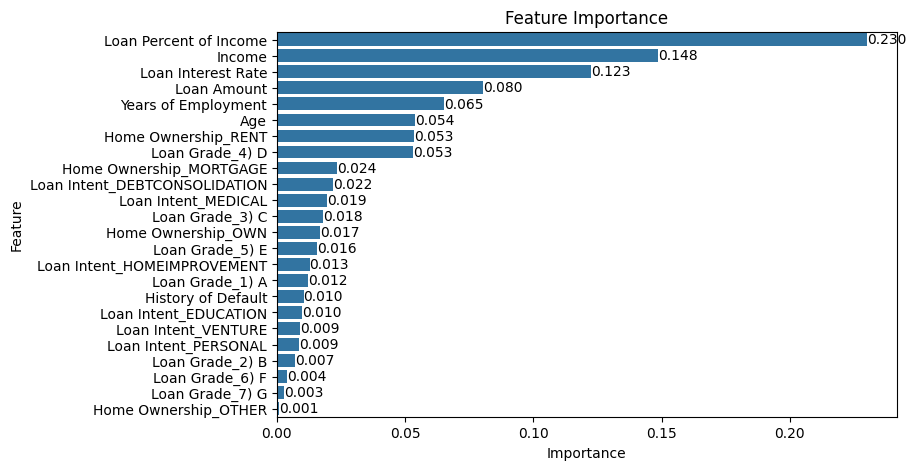

In [28]:
y = df_modeling_data['Default (target)']
X = df_modeling_data.drop('Default (target)',axis = 1)
#Fitting a default Random Forest model to run for Feature importance
model = RandomForestClassifier(random_state=2024).fit(X, y)
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

#plotting the results of the feature importance
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importances)
for p in ax.patches:
    # Get information to display the label
    x = p.get_x() + p.get_width()  
    y = p.get_y() + p.get_height() / 2   
    value = p.get_width()                
    ax.text(x, y, f'{value:.3f}',         
            va='center')                  
plt.title('Feature Importance')
plt.show()

# Modeling All Selected Features
Below I am modeling the data using: 
+ Logistic Regression (Default parameters)
+ Decision Tree (Default parameters)
+ Random Forest (Default parameters)
+ Logistic Regression (Tuned parameters using hyperparameter tuning)
+ Decision Tree (Tuned parameters using hyperparameter tuning)
+ Random Forest (Tuned parameters using hyperparameter tuning)


Although I didn't in this instance, I typically experiment with incrementally reducing the number of features to optimize the model further using Feature Importance.

In [29]:
#Splitting the training and testing data 
X = df_modeling_data.drop('Default (target)', axis=1)  
y = df_modeling_data['Default (target)']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

## Logistic Regression (Default)

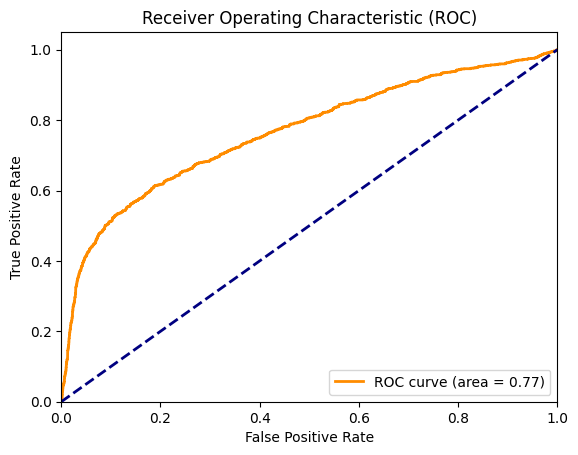

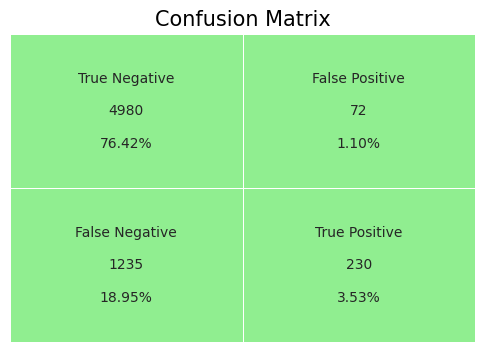

In [36]:
# Fitting the model
logreg = LogisticRegression(solver='liblinear', random_state=42)
logreg.fit(X_train, y_train)

# Predictions and probabilities for the test data
y_pred_lr = logreg.predict(X_test)
y_pred_proba_lr = logreg.predict_proba(X_test)[:, 1]

# Calculation of performance metrics
f1_lr = f1_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
logloss_lr = log_loss(y_test, y_pred_proba_lr)

# Generating an HTML string to display the performance metrics in a formatted list
html_string = """
<h4>Performance Metrics for the Logistic Regression Model (Default)</h4>
<ul>
    <li>F1 Score: {f1}</li>
    <li>Recall: {recall}</li>
    <li>Precision: {precision}</li>
    <li>AUC: {auc}</li>
    <li>Log Loss: {logloss}</li>
</ul>
""".format(f1=round(f1_lr,4), recall=round(recall_lr,4), precision=round(precision_lr,4), auc=round(auc_lr,4), logloss=round(logloss_lr,4))
display(HTML(html_string))

# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lr)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal 45 degree line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_lr)
labels = np.array([['True Negative\n', 'False Positive\n'], ['False Negative\n', 'True Positive\n']])
counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
percentages = ["\n{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
annot = np.array([["{0}\n{1}\n{2}".format(label, count, percentage) for label, count, percentage in zip(labels.flatten(), counts, percentages)]])
annot = annot.reshape(2,2)
plt.figure(figsize=(6,4)) 
ax = sns.heatmap(cm, annot=annot, fmt='', linewidths=.5, cmap=['lightgreen'], cbar=False)
plt.title('Confusion Matrix', size=15)
ax.axis('off')
plt.show()

## Decision Tree (Default)

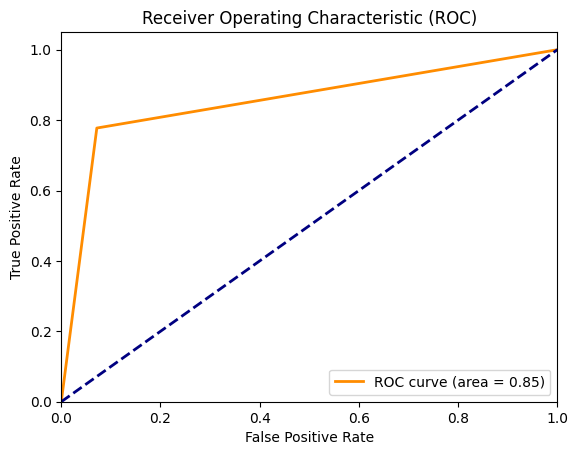

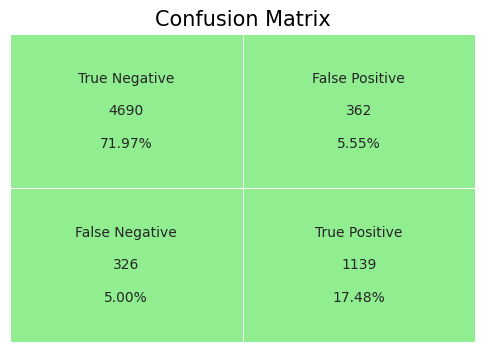

In [37]:
# Fitting the model
dt = DecisionTreeClassifier(random_state=2023)
dt.fit(X_train, y_train)

# Predictions and probabilities for the test data
y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)[:, 1] 

# Calculation of performance metrics
f1_dt = f1_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
logloss_dt = log_loss(y_test, y_pred_proba_dt)

# Generating an HTML string to display the performance metrics in a formatted list
html_string = """
<h4>Performance Metrics for the Decision Tree Model (Default)</h4>
<ul>
    <li>F1 Score: {f1}</li>
        <ul>
        <li><i>F1 score combines precision and recall into a single, balanced indicator of performance.</i></li>
        </ul>
    <li>Recall: {recall}</li>
        <ul>
        <li><i>Recall indicates the proportion of actual positives correctly identified. Higher recall means fewer true cases were missed.</i></li>
        </ul>
    <li>Precision: {precision}</li>
        <ul>
        <li><i>Precision indicates the performance of positive predictions. A higher precision means that a greater proportion of positive were correctly identified.</i></li>
        </ul>
    <li>AUC: {auc}</li>
        <ul>
        <li><i>AUC (Area Under the Curve) measures the model's ability to distinguish between classes. A score closer to 1 indicates a very good model.</i></li>
        </ul>
    <li>Log Loss: {logloss}</li>
        <ul>
        <li><i>Log Loss reflects the uncertainty of the predictions. Lower values mean more confident predictions. This is good for comparing different models on the same data.</i></li>
        </ul>
</ul>
""".format(f1=round(f1_dt, 4), recall=round(recall_dt, 4), precision=round(precision_dt, 4), auc=round(auc_dt, 4), logloss=round(logloss_dt, 4))
display(HTML(html_string))

# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_dt)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal 45 degree line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_dt)
labels = np.array([['True Negative\n', 'False Positive\n'], ['False Negative\n', 'True Positive\n']])
counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
percentages = ["\n{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
annot = np.array([["{0}\n{1}\n{2}".format(label, count, percentage) for label, count, percentage in zip(labels.flatten(), counts, percentages)]])
annot = annot.reshape(2,2)
plt.figure(figsize=(6,4)) 
ax = sns.heatmap(cm, annot=annot, fmt='', linewidths=.5, cmap=['lightgreen'], cbar=False)
plt.title('Confusion Matrix', size=15)
ax.axis('off')
plt.show()

## Random Forest (Default)

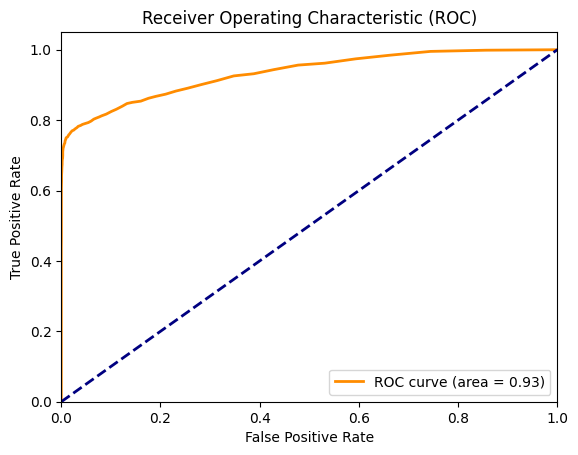

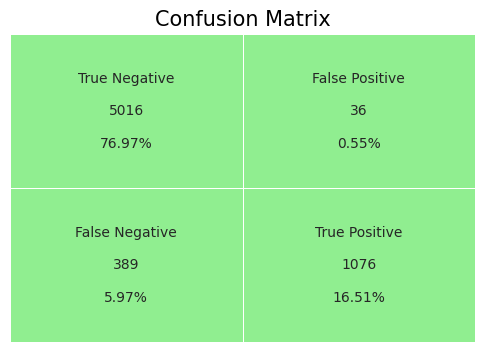

In [38]:
# Fitting the model
rf = RandomForestClassifier(n_estimators=100, random_state=2023)  # 100 dec trees in the forest
rf.fit(X_train, y_train)

# Predictions and probabilities for the test data
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculation of performance metrics
f1_rf = f1_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
logloss_rf = log_loss(y_test, y_pred_proba_rf)

# Generating an HTML string to display the performance metrics in a formatted list
html_string = """
<h4>Performance Metrics for the Random Forest Model (Default)</h4>
<ul>
    <li>F1 Score: {f1}</li>
        <ul>
        <li><i>F1 score combines precision and recall into a single, balanced indicator of performance.</i></li>
        </ul>
    <li>Recall: {recall}</li>
        <ul>
        <li><i>Recall indicates the proportion of actual positives correctly identified. Higher recall means fewer true cases were missed.</i></li>
        </ul>
    <li>Precision: {precision}</li>
        <ul>
        <li><i>Precision indicates the performance of positive predictions. A higher precision means that a greater proportion of positive identifications was actually correct.</i></li>
        </ul>
    <li>AUC: {auc}</li>
        <ul>
        <li><i>AUC (Area Under the Curve) measures the model's ability to distinguish between classes. A score closer to 1 indicates a very good model.</i></li>
        </ul>
    <li>Log Loss: {logloss}</li>
        <ul>
        <li><i>Log Loss reflects the uncertainty of the predictions. Lower values mean more confident predictions. This is good for comparing different models on the same data.</i></li>
        </ul>
</ul>
""".format(f1=round(f1_rf, 4), recall=round(recall_rf, 4), precision=round(precision_rf, 4), auc=round(auc_rf, 4), logloss=round(logloss_rf, 4))
display(HTML(html_string))

# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal 45 degree line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_rf)
labels = np.array([['True Negative\n', 'False Positive\n'], ['False Negative\n', 'True Positive\n']])
counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
percentages = ["\n{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
annot = np.array([["{0}\n{1}\n{2}".format(label, count, percentage) for label, count, percentage in zip(labels.flatten(), counts, percentages)]])
annot = annot.reshape(2,2)
plt.figure(figsize=(6,4)) 
ax = sns.heatmap(cm, annot=annot, fmt='', linewidths=.5, cmap=['lightgreen'], cbar=False)
plt.title('Confusion Matrix', size=15)
ax.axis('off')
plt.show()

## Logistic Regression (Tuned)

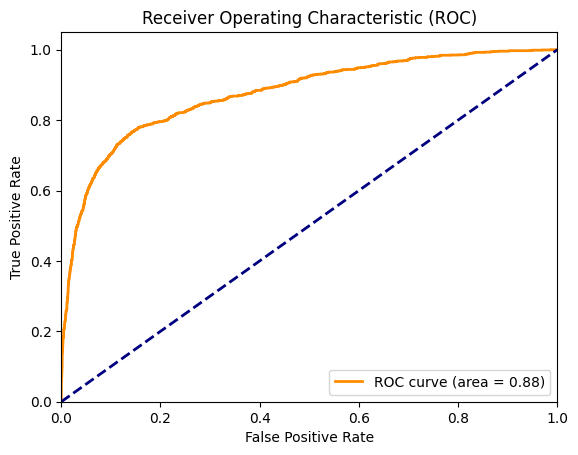

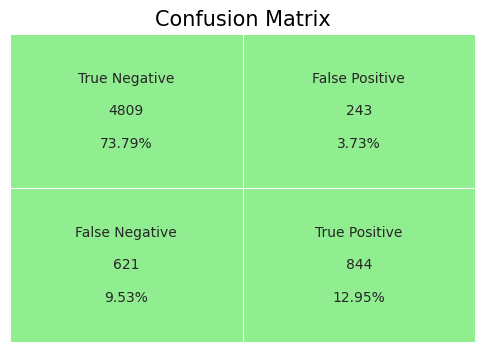

In [39]:
# Define the parameter grid for the Logistic Regression classifier
parameters = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear']
}

logreg_cv = GridSearchCV(LogisticRegression(random_state=42), parameters, cv=5, scoring='roc_auc')
logreg_cv.fit(X_train, y_train)

best_lr = logreg_cv.best_estimator_ # Extract the best model after grid search

# Predictions and probabilities for the test data using the best model
y_pred_lr = best_lr.predict(X_test)
y_pred_proba_lr = best_lr.predict_proba(X_test)[:, 1]

# Calculation of performance metrics
f1_lr = f1_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
logloss_lr = log_loss(y_test, y_pred_proba_lr)

# Generating an HTML string to display the performance metrics in a formatted list
html_string = """
<h4>Performance Metrics for the Logistic Regression Model (Tuned)</h4>
<ul>
    <li>F1 Score: {f1}</li>
        <ul>
        <li><i>F1 score combines precision and recall into a single, balanced indicator of performance.</i></li>
        </ul>
    <li>Recall: {recall}</li>
        <ul>
        <li><i>Recall indicates the proportion of actual positives correctly identified. Higher recall means fewer true cases were missed.</i></li>
        </ul>
    <li>Precision: {precision}</li>
        <ul>
        <li><i>Precision indicates the performance of positive predictions. A higher precision means that a greater proportion of positive identifications was actually correct.</i></li>
        </ul>
    <li>AUC: {auc}</li>
        <ul>
        <li><i>AUC (Area Under the Curve) measures the model's ability to distinguish between classes. A score closer to 1 indicates a very good model.</i></li>
        </ul>
    <li>Log Loss: {logloss}</li>
        <ul>
        <li><i>Log Loss reflects the uncertainty of the predictions. Lower values mean more confident predictions. This is good for comparing different models on the same data.</i></li>
        </ul>
</ul>
""".format(f1=round(f1_lr, 4), recall=round(recall_lr, 4), precision=round(precision_lr, 4), auc=round(auc_lr, 4), logloss=round(logloss_lr, 4))
display(HTML(html_string))

# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lr)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_lr)
labels = np.array([['True Negative\n', 'False Positive\n'], ['False Negative\n', 'True Positive\n']])
counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
percentages = ["\n{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
annot = np.array([["{0}\n{1}\n{2}".format(label, count, percentage) for label, count, percentage in zip(labels.flatten(), counts, percentages)]])
annot = annot.reshape(2,2)
plt.figure(figsize=(6,4))
ax = sns.heatmap(cm, annot=annot, fmt='', linewidths=.5, cmap=['lightgreen'], cbar=False)
plt.title('Confusion Matrix', size=15)
ax.axis('off')
plt.show()


## Decision Tree (Tuned)

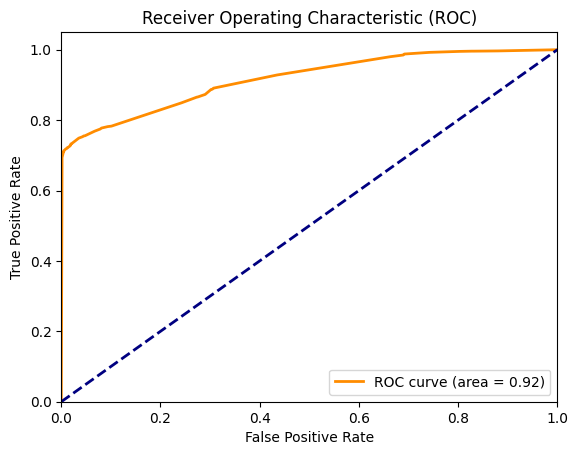

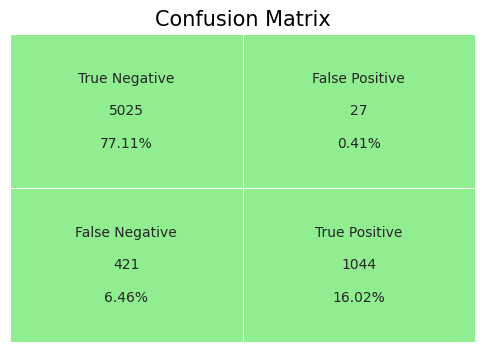

In [40]:
# Define the parameter grid for the Decision Tree classifier
parameters_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5)
}

dt_cv = GridSearchCV(DecisionTreeClassifier(random_state=2023), parameters_dt, cv=5, scoring='roc_auc')
dt_cv.fit(X_train, y_train)

best_dt = dt_cv.best_estimator_ # Extract the best model after grid search

# Predictions and probabilities for the test data using the best model
y_pred_dt = best_dt.predict(X_test)
y_pred_proba_dt = best_dt.predict_proba(X_test)[:, 1]

# Calculation of performance metrics
f1_dt = f1_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
logloss_dt = log_loss(y_test, y_pred_proba_dt)

# Generating an HTML string to display the performance metrics in a formatted list
html_string = """
<h4>Performance Metrics for the Decision Tree Model (Tuned)</h4>
<ul>
    <li>F1 Score: {f1}</li>
        <ul>
        <li><i>F1 score combines precision and recall into a single, balanced indicator of performance.</i></li>
        </ul>
    <li>Recall: {recall}</li>
        <ul>
        <li><i>Recall indicates the proportion of actual positives correctly identified. Higher recall means fewer true cases were missed.</i></li>
        </ul>
    <li>Precision: {precision}</li>
        <ul>
        <li><i>Precision indicates the performance of positive predictions. A higher precision means that a greater proportion of positive identifications was actually correct.</i></li>
        </ul>
    <li>AUC: {auc}</li>
        <ul>
        <li><i>AUC (Area Under the Curve) measures the model's ability to distinguish between classes. A score closer to 1 indicates a very good model.</i></li>
        </ul>
    <li>Log Loss: {logloss}</li>
        <ul>
        <li><i>Log Loss reflects the uncertainty of the predictions. Lower values mean more confident predictions. This is good for comparing different models on the same data.</i></li>
        </ul>
</ul>
""".format(f1=round(f1_dt, 4), recall=round(recall_dt, 4), precision=round(precision_dt, 4), auc=round(auc_dt, 4), logloss=round(logloss_dt, 4))
display(HTML(html_string))

# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_dt)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_dt)
labels = np.array([['True Negative\n', 'False Positive\n'], ['False Negative\n', 'True Positive\n']])
counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
percentages = ["\n{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
annot = np.array([["{0}\n{1}\n{2}".format(label, count, percentage) for label, count, percentage in zip(labels.flatten(), counts, percentages)]])
annot = annot.reshape(2,2)
plt.figure(figsize=(6,4)) 
ax = sns.heatmap(cm, annot=annot, fmt='', linewidths=.5, cmap=['lightgreen'], cbar=False)
plt.title('Confusion Matrix', size=15)
ax.axis('off')
plt.show()

## Random Forest (Tuned)

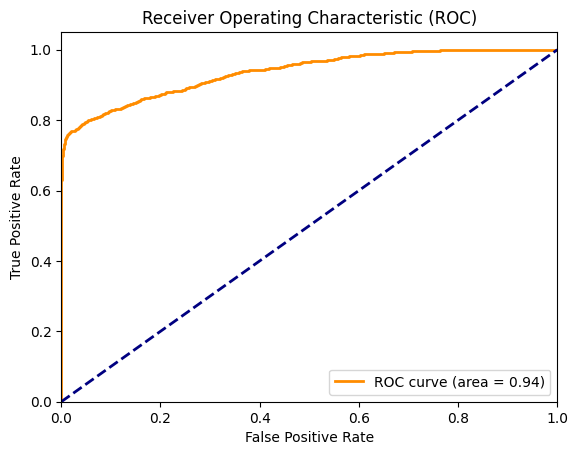

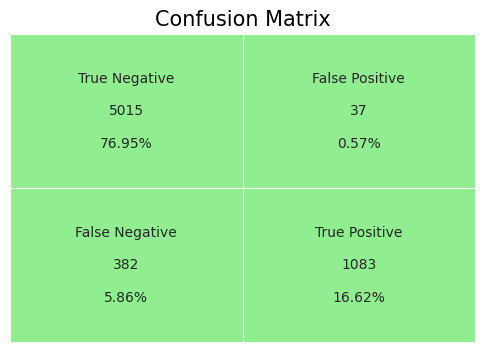

In [41]:
# Define the parameter grid for the Random Forest classifier

parameters_rf = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_cv = GridSearchCV(RandomForestClassifier(random_state=2023), parameters_rf, cv=5, scoring='roc_auc')
rf_cv.fit(X_train, y_train)

best_rf = rf_cv.best_estimator_  # Extract the best model after grid search

# Predictions and probabilities for the test data using the best model
y_pred_rf = best_rf.predict(X_test)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Calculation of performance metrics
f1_rf = f1_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
logloss_rf = log_loss(y_test, y_pred_proba_rf)

# Generating an HTML string to display the performance metrics in a formatted list
html_string = """
<h4>Performance Metrics for the Random Forest Model (Tuned)</h4>
<ul>
    <li>F1 Score: {f1}</li>
        <ul>
        <li><i>F1 score combines precision and recall into a single, balanced indicator of performance.</i></li>
        </ul>
    <li>Recall: {recall}</li>
        <ul>
        <li><i>Recall indicates the proportion of actual positives correctly identified. Higher recall means fewer true cases were missed.</i></li>
        </ul>
    <li>Precision: {precision}</li>
        <ul>
        <li><i>Precision indicates the performance of positive predictions. A higher precision means that a greater proportion of positive identifications was actually correct.</i></li>
        </ul>
    <li>AUC: {auc}</li>
        <ul>
        <li><i>AUC (Area Under the Curve) measures the model's ability to distinguish between classes. A score closer to 1 indicates a very good model.</i></li>
        </ul>
    <li>Log Loss: {logloss}</li>
        <ul>
        <li><i>Log Loss reflects the uncertainty of the predictions. Lower values mean more confident predictions. This is good for comparing different models on the same data.</i></li>
        </ul>
</ul>
""".format(f1=round(f1_rf, 4), recall=round(recall_rf, 4), precision=round(precision_rf, 4), auc=round(auc_rf, 4), logloss=round(logloss_rf, 4))
display(HTML(html_string))

# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_rf)
labels = np.array([['True Negative\n', 'False Positive\n'], ['False Negative\n', 'True Positive\n']])
counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
percentages = ["\n{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
annot = np.array([["{0}\n{1}\n{2}".format(label, count, percentage) for label, count, percentage in zip(labels.flatten(), counts, percentages)]])
annot = annot.reshape(2,2)
plt.figure(figsize=(6,4))
ax = sns.heatmap(cm, annot=annot, fmt='', linewidths=.5, cmap=['lightgreen'], cbar=False)
plt.title('Confusion Matrix', size=15)
ax.axis('off')
plt.show()

My next steps would typically involve evaluating which features could be eliminated to simplify the model, aiming to find an optimal balance between model complexity, explainability, and performance. Based on the results observed, my preference is for the Tuned Decision Tree model. The incremental performance gain provided by the Tuned Random Forest does not outweigh its higher computational demands and potential for causing confusion among stakeholders. Decision trees offer straightforward explanations and visualizations, in addition to being less resource-intensive. I exported the models as `.pkl` files for deployment in production environments below.

**NEXT STEPS:** To automate the process of updating models with new data, generating predictions, prediction probabilities, scores, and monitoring for data drift. This setup will ensure regular automated updates and maintenance of the system. Many times, I find myself rebuilding the model in TensorFlow for automated production refreshes. Additionally, I typically implement Champion/Challenger model approaches for performance monitoring. This strategy has allowed stakeholders to select the most appropriate model based on specific needs—whether that's a higher Recall or Precision or Balanced approach—and the latest performance metrics. 

# Export Models for Production

In [42]:
# Define base path for models directory
models_dir = '/Users/jeffreyblack/Projects/TrustageTechnicalProject/models'

# Create directory if doesn't exist
os.makedirs(models_dir, exist_ok=True)

# Define filenames for each model
filenames = [
    os.path.join(models_dir, 'tuned_logistic_regression_model.pkl'),
    os.path.join(models_dir, 'tuned_decision_tree_model.pkl'),
    os.path.join(models_dir, 'tuned_random_forest_model.pkl')
]

models = [best_lr, best_dt, best_rf]

# Iterate through each model and its corresponding filename
for filename, model in zip(filenames, models):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)